---
# Pilot SRF

This notebook describes the first attempt with the hole-response experiment. The pipeline starts of after [call_lsprep](https://github.com/gjheij/linescanning/blob/main/bin/call_lsprep), which creates an `h5`-file with all relevant dataframes

In [239]:
from linescanning import (
    utils,
    dataset,
    fitting,
    plotting,
    glm,
    pycortex
)
import itertools
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pyplot as plt
import os
import pingouin as pg
opj = os.path.join

## Data loader

In [2]:
deriv = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives"
subject = "sub-002"
# ribbon = (357,366)

# get h5-file
data_file = opj(deriv, "lsprep", subject, f"{subject}_ses-2_desc-preproc_bold.h5")

# load in
obj_ = dataset.Dataset(
    data_file,
    verbose=True
)

DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-002/sub-002_ses-2_desc-preproc_bold.h5
 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets

DATASET: created


In [3]:
df_onsets = obj_.fetch_onsets()
df_func = obj_.fetch_fmri(dtype="raw")
df_filt = obj_.fetch_fmri(dtype="psc")

Fetching dataframe from attribute 'df_func_raw'
Fetching dataframe from attribute 'df_func_psc'


In [4]:
run_ids = obj_.get_runs(df_func)
ribbon = (360,368)
# df_rib = utils.select_from_df(df_func, expression="ribbon", indices=ribbon)

try:
    srfa = utils.select_from_df(df_func, expression="task = SRFa")
except:
    srfa = df_func.copy()
srfa

vox 0     vox 1     vox 2     vox 3     vox 4  \
subject run t                                                           
002     1   0.000    0.692833  0.896828  0.628063  1.024324  0.969457   
            0.105    0.664164  0.835594  0.610455  0.759294  0.832200   
            0.210    0.688895  0.881749  0.619996  1.041092  1.026769   
            0.315    0.670367  1.123813  0.635335  0.861541  1.003294   
            0.420    0.639959  0.954805  0.667687  0.980896  0.908417   
...                       ...       ...       ...       ...       ...   
        6   335.475  0.675385  1.322775  1.225339  1.138113  1.013361   
            335.580  0.637220  1.453323  1.106429  1.277480  0.886826   
            335.685  0.651362  1.297754  1.324164  1.370090  1.024805   
            335.790  0.805927  1.346845  1.107264  1.454646  1.101773   
            335.895  0.768595  1.435856  1.342850  1.406574  1.050145   

                        vox 5     vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
002     1   0.000    0.739937  0.794050  0.804902  1.033142  0.868835  ...   
            0.105    0.811630  0.906345  0.791038  0.852015  0.790522  ...   
            0.210    1.034379  1.033413  0.793636  0.895715  0.894236  ...   
            0.315    0.787779  0.976134  0.888301  0.937294  0.937306  ...   
            0.420    0.860178  0.996759  0.737529  1.064795  0.951712  ...   
...                       ...       ...       ...       ...       ...  ...   
        6   335.475  1.222408  1.139613  0.944136  1.158420  1.561036  ...   
            335.580  1.016413  1.099445  0.923863  0.926461  1.476023  ...   
            335.685  1.044768  0.956861  0.895894  0.897824  1.695583  ...   
            335.790  1.220582  1.050363  0.705019  0.828115  1.446140  ...   
            335.895  1.155160  0.983058  0.872089  1.036942  1.618852  ...   

                      vox 710   vox 711   vox 712   vox 713   vox 714  \
subject run t                                                           
002     1   0.000    0.564416  0.444268  0.471021  0.350970  0.611075   
            0.105    0.374575  0.491022  0.652807  0.574483  0.432197   
            0.210    0.445625  0.479132  0.512166  0.439999  0.706207   
            0.315    0.364860  0.385409  0.358977  0.308155  0.678826   
            0.420    0.145689  0.300530  0.600160  0.390401  0.596024   
...                       ...       ...       ...       ...       ...   
        6   335.475  0.534231  0.433461  0.484201  0.285984  0.377191   
            335.580  0.515140  0.460050  0.620005  0.526522  0.502675   
            335.685  0.509314  0.415335  0.713366  0.398692  0.438265   
            335.790  0.345324  0.653087  0.710644  0.327922  0.439988   
            335.895  0.381837  0.343586  0.422961  0.380620  0.473778   

                      vox 715   vox 716   vox 717   vox 718   vox 719  
subject run t                                                          
002     1   0.000    0.333631  0.441773  0.340478  0.427405  0.368318  
            0.105    0.445951  0.649036  0.593886  0.350499  0.349556  
            0.210    0.341515  0.380207  0.389017  0.599656  0.476652  
            0.315    0.380429  0.376609  0.483482  0.400366  0.607699  
            0.420    0.430368  0.372128  0.490635  0.654492  0.422603  
...                       ...       ...       ...       ...       ...  
        6   335.475  0.425921  0.386440  0.565892  0.602572  0.556921  
            335.580  0.353509  0.316138  0.432791  0.321228  0.352262  
            335.685  0.434416  0.446423  0.453401  0.342356  0.395908  
            335.790  0.402982  0.415821  0.726147  0.556597  0.294785  
            335.895  0.355393  0.412193  0.324438  0.516554  0.559201  

[19200 rows x 720 columns]

comparing run ('1', '2')
comparing run ('1', '3')
comparing run ('1', '4')
comparing run ('1', '5')
comparing run ('1', '6')
comparing run ('2', '3')
comparing run ('2', '4')


IndexError: index 6 is out of bounds for axis 0 with size 6

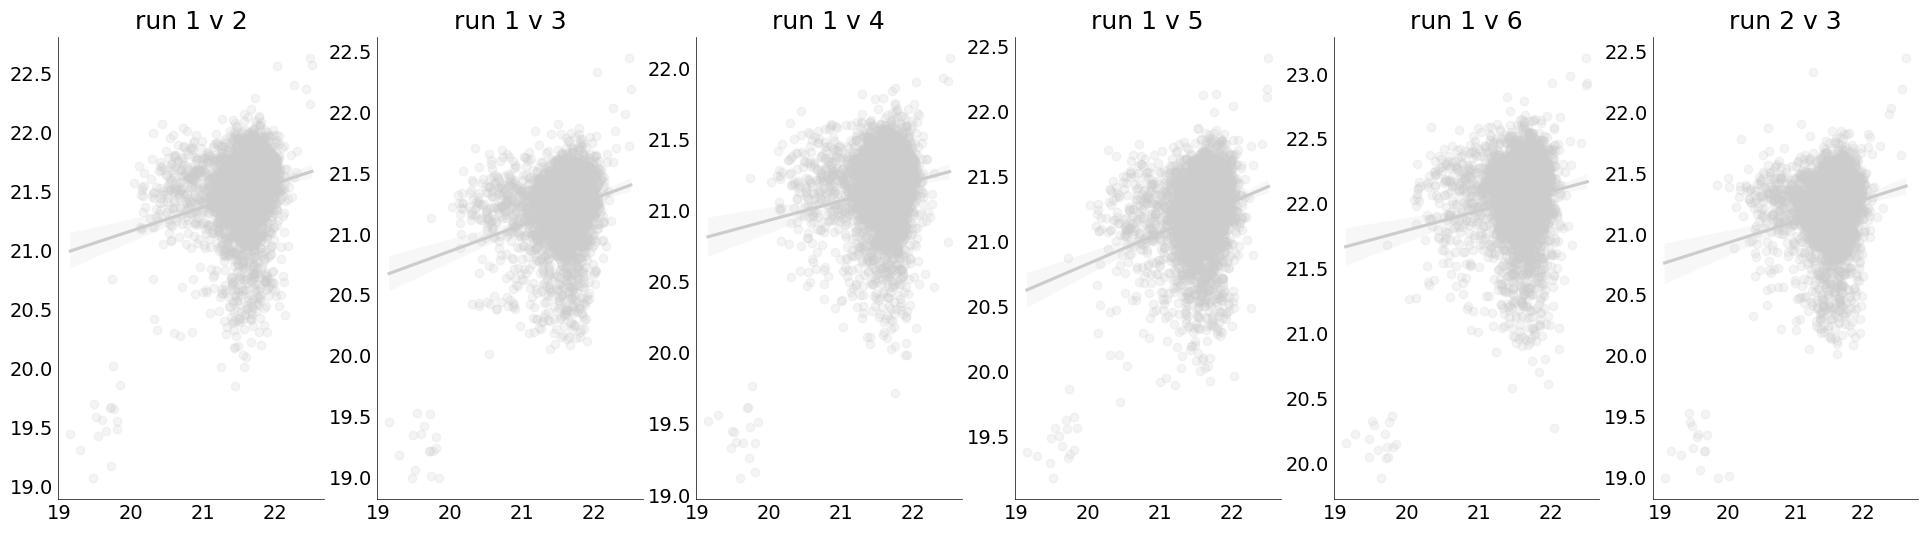

In [7]:
%matplotlib inline
fig,axs = plt.subplots(ncols=len(run_ids), figsize=(24,6))
comb = list(itertools.combinations(run_ids, 2))
for ix,c in enumerate(comb):
    print(f"comparing run {c}")
    arr1 = utils.select_from_df(srfa, expression=f"run = {c[0]}").mean(axis=1)
    arr2 = utils.select_from_df(srfa, expression=f"run = {c[1]}").mean(axis=1)

    # corr = signal.correlate2d(
    #     arr1,
    #     arr2, 
    #     boundary='symm', 
    #     mode='same')

    plotting.LazyCorr(
        arr1,
        arr2, 
        axs=axs[ix], 
        title=f"run {c[0]} v {c[1]}", 
        scatter_kwargs={"alpha": 0.2})

fig.suptitle("cross-correlation", fontsize=32, y=1.05)
plt.show()

In [5]:
# average across runs within tasks
try:
    df_avg = df_func.groupby(["subject","task","t"]).mean()
except:
    df_avg = df_func.groupby(["subject","t"]).mean()
df_avg

vox 0     vox 1     vox 2     vox 3     vox 4     vox 5  \
subject t                                                                     
002     0.000    0.846760  1.107231  1.061895  1.127996  1.003150  0.910025   
        0.105    0.840604  1.119357  1.008349  1.061751  0.933632  0.852853   
        0.210    0.967924  1.243802  1.146142  1.225367  1.142514  1.021860   
        0.315    0.817941  1.226624  1.146796  1.207396  1.082253  1.020451   
        0.420    0.832550  1.148341  1.163575  1.250748  1.051400  1.054419   
...                   ...       ...       ...       ...       ...       ...   
        335.475  0.906168  1.109331  1.208757  1.209362  1.036680  1.101740   
        335.580  0.932995  1.203737  1.158531  1.158397  1.019768  0.983465   
        335.685  0.877458  1.191238  1.192956  1.299228  1.014281  1.014263   
        335.790  0.863594  1.185585  1.255359  1.223479  1.150367  0.999575   
        335.895  0.962433  1.252099  1.221846  1.279225  1.026261  1.043396   

                    vox 6     vox 7     vox 8     vox 9  ...   vox 710  \
subject t                                                ...             
002     0.000    0.935049  0.811234  1.016344  1.048335  ...  0.465507   
        0.105    0.931179  0.853500  0.988508  1.125133  ...  0.391494   
        0.210    1.065088  1.007789  1.166172  1.202974  ...  0.458366   
        0.315    1.115492  0.937190  1.104585  1.260339  ...  0.409760   
        0.420    0.989385  0.951067  1.077089  1.223663  ...  0.315094   
...                   ...       ...       ...       ...  ...       ...   
        335.475  1.005874  0.990328  1.032276  1.223111  ...  0.476495   
        335.580  1.033511  1.082757  1.060323  1.195598  ...  0.451221   
        335.685  1.073672  0.984134  1.047679  1.229580  ...  0.445064   
        335.790  0.978891  0.888558  0.978655  1.127882  ...  0.485828   
        335.895  1.090235  1.012849  0.996041  1.197294  ...  0.470447   

                  vox 711   vox 712   vox 713   vox 714   vox 715   vox 716  \
subject t                                                                     
002     0.000    0.535817  0.517499  0.402593  0.440003  0.506223  0.462818   
        0.105    0.487637  0.551179  0.425474  0.423429  0.463702  0.444455   
        0.210    0.519732  0.539102  0.480185  0.462191  0.505647  0.466763   
        0.315    0.448258  0.568760  0.379578  0.441152  0.504658  0.437932   
        0.420    0.472171  0.538602  0.422048  0.477491  0.504659  0.496576   
...                   ...       ...       ...       ...       ...       ...   
        335.475  0.404402  0.468471  0.468614  0.509926  0.565434  0.534369   
        335.580  0.468845  0.520998  0.495302  0.528785  0.524346  0.423836   
        335.685  0.552789  0.524258  0.396418  0.441217  0.467890  0.431654   
        335.790  0.486637  0.545501  0.429419  0.514941  0.519528  0.408291   
        335.895  0.515149  0.509970  0.490468  0.490580  0.452482  0.496529   

                  vox 717   vox 718   vox 719  
subject t                                      
002     0.000    0.473543  0.454019  0.456725  
        0.105    0.486178  0.431817  0.498092  
        0.210    0.483391  0.492118  0.496458  
        0.315    0.499450  0.412603  0.427312  
        0.420    0.490653  0.551987  0.446838  
...                   ...       ...       ...  
        335.475  0.565775  0.486384  0.528124  
        335.580  0.516803  0.511524  0.461501  
        335.685  0.551411  0.477938  0.487272  
        335.790  0.553848  0.452298  0.421865  
        335.895  0.560787  0.507695  0.562924  

[3200 rows x 720 columns]

In [36]:
# select ribbon voxels
# ribbon = (346,359)
ribbon = (360,369)
df_ribbon = utils.select_from_df(df_filt.groupby(["subject","t"]).mean(), expression="ribbon", indices=ribbon)
df_ribbon

vox 360   vox 361   vox 362   vox 363   vox 364   vox 365  \
subject t                                                                     
002     0.000    0.213488 -0.718330  0.440727  0.018664 -0.138749  0.094931   
        0.105   -0.262278 -0.439606  0.303754  0.003279 -0.254687 -0.345201   
        0.210   -0.035692 -0.018689 -0.163128 -0.079506 -0.453055  0.285292   
        0.315   -0.414393 -0.244478 -0.201566 -0.278917  0.024515 -0.390553   
        0.420   -0.345463  0.021505  0.020318  0.426147  0.067006  0.364578   
...                   ...       ...       ...       ...       ...       ...   
        335.475 -0.409064 -0.130814  0.247784  0.016370 -0.005411 -0.299745   
        335.580 -0.638831 -0.304427 -0.623264 -0.088718 -0.564508  0.142534   
        335.685 -0.460206 -0.261950 -0.149429 -0.618435 -0.398216 -0.809924   
        335.790 -0.219280 -0.464855 -0.482927 -0.420657 -0.219124 -0.641698   
        335.895 -0.707420 -0.268695 -0.865966 -0.949486 -0.631078 -0.198962   

                  vox 366   vox 367   vox 368  
subject t                                      
002     0.000   -0.014397  0.555425 -0.225076  
        0.105   -0.004276  0.267479  0.089727  
        0.210   -0.330980 -0.217049  0.308846  
        0.315    0.109900  0.246156 -0.175924  
        0.420    0.144934  0.464448  0.386084  
...                   ...       ...       ...  
        335.475 -0.333360 -0.272025  0.308893  
        335.580 -0.738914 -0.204686 -0.543794  
        335.685 -0.364119 -0.099592 -0.317502  
        335.790 -0.563060 -0.679218 -0.301458  
        335.895 -0.336742 -0.206343 -0.123571  

[3200 rows x 9 columns]

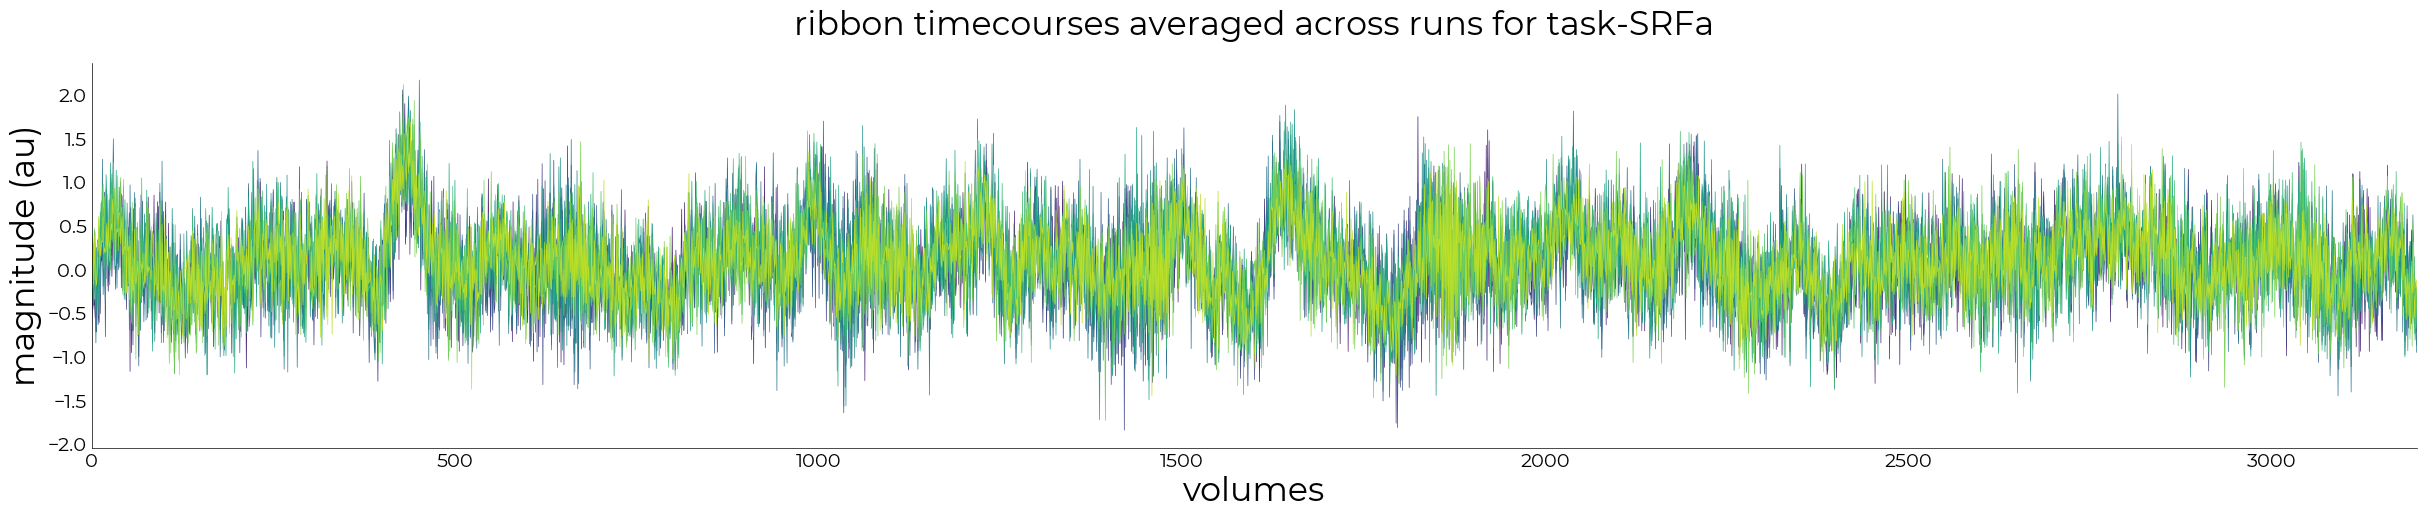

In [37]:
%matplotlib inline
# plot timecourses
try:
    task1_data = utils.select_from_df(df_ribbon, expression="task = SRFa")
except:
    task1_data = df_ribbon

plotting.LazyPlot(
    list(task1_data.T.to_numpy()),
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=24,
    # add_hline="mean",
    line_width=0.5,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

In [38]:
df_ribbon

vox 360   vox 361   vox 362   vox 363   vox 364   vox 365  \
subject t                                                                     
002     0.000    0.213488 -0.718330  0.440727  0.018664 -0.138749  0.094931   
        0.105   -0.262278 -0.439606  0.303754  0.003279 -0.254687 -0.345201   
        0.210   -0.035692 -0.018689 -0.163128 -0.079506 -0.453055  0.285292   
        0.315   -0.414393 -0.244478 -0.201566 -0.278917  0.024515 -0.390553   
        0.420   -0.345463  0.021505  0.020318  0.426147  0.067006  0.364578   
...                   ...       ...       ...       ...       ...       ...   
        335.475 -0.409064 -0.130814  0.247784  0.016370 -0.005411 -0.299745   
        335.580 -0.638831 -0.304427 -0.623264 -0.088718 -0.564508  0.142534   
        335.685 -0.460206 -0.261950 -0.149429 -0.618435 -0.398216 -0.809924   
        335.790 -0.219280 -0.464855 -0.482927 -0.420657 -0.219124 -0.641698   
        335.895 -0.707420 -0.268695 -0.865966 -0.949486 -0.631078 -0.198962   

                  vox 366   vox 367   vox 368  
subject t                                      
002     0.000   -0.014397  0.555425 -0.225076  
        0.105   -0.004276  0.267479  0.089727  
        0.210   -0.330980 -0.217049  0.308846  
        0.315    0.109900  0.246156 -0.175924  
        0.420    0.144934  0.464448  0.386084  
...                   ...       ...       ...  
        335.475 -0.333360 -0.272025  0.308893  
        335.580 -0.738914 -0.204686 -0.543794  
        335.685 -0.364119 -0.099592 -0.317502  
        335.790 -0.563060 -0.679218 -0.301458  
        335.895 -0.336742 -0.206343 -0.123571  

[3200 rows x 9 columns]

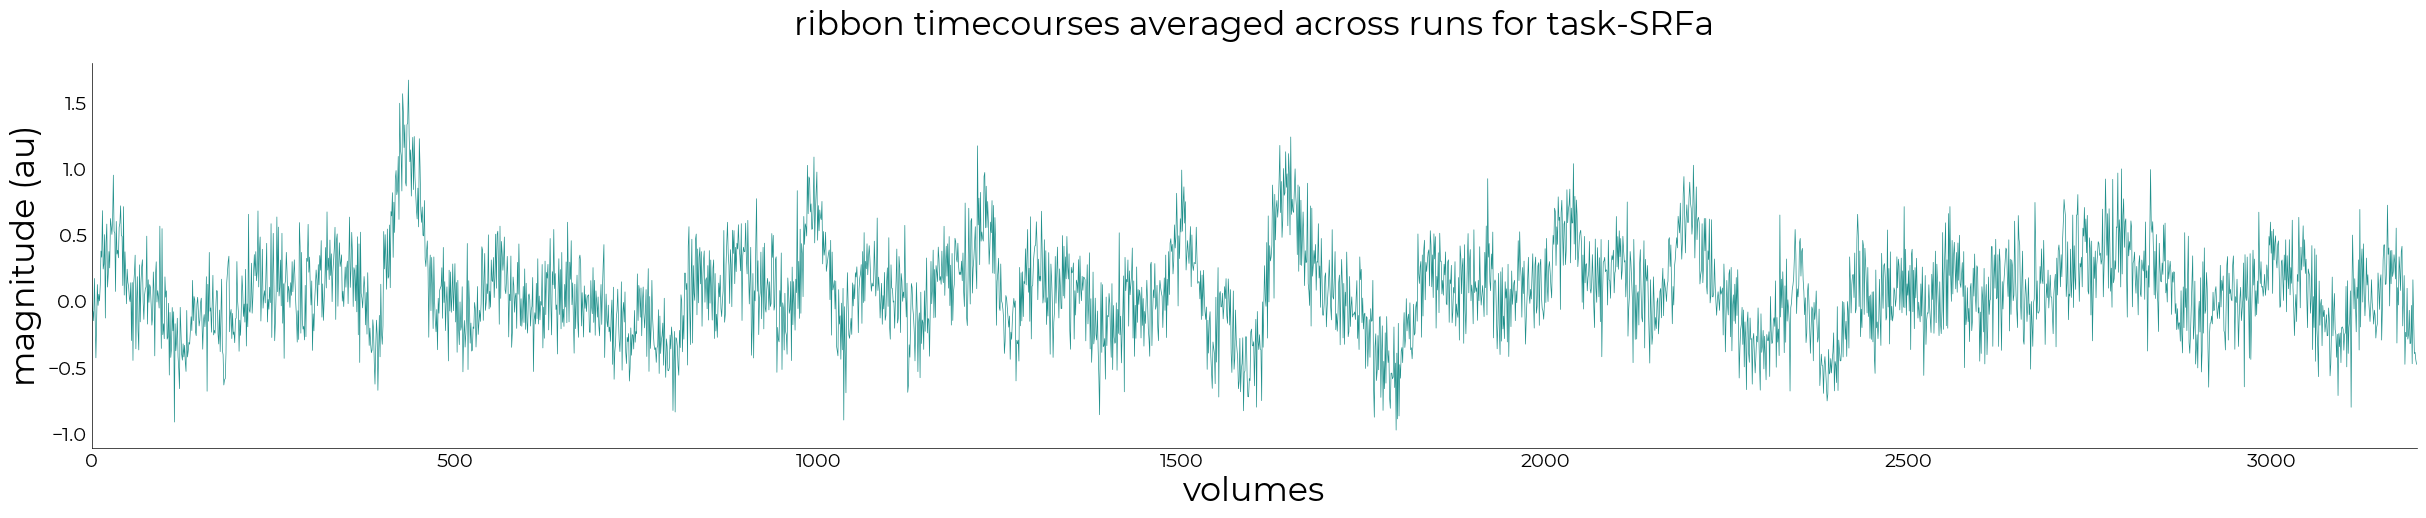

In [39]:
# select ribbon voxels
df_ribbon_avg = pd.DataFrame(df_ribbon.mean(axis=1), columns=["average"])
df_ribbon_avg

# plot timecourses
try:
    task1_avg = utils.select_from_df(df_ribbon_avg, expression="task = SRFa")
except:
    task1_avg = df_ribbon_avg.copy()

plotting.LazyPlot(
    list(task1_avg.T.to_numpy()),
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=24,
    # add_hline=0,
    line_width=0.5,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

In [40]:
task_ids = utils.get_ids(df_onsets)

if len(task_ids) > 0:
    # switch our task-ID for run-IDs so we can flop everything in nideconv
    renamed_func = []
    renamed_onsets = []

    task_onsets = utils.select_from_df(df_onsets, expression="event_type != response")
    for ix,task in enumerate(["SRFa","SRFb"]):
        
        # sort out func
        df = utils.select_from_df(df_ribbon_avg, expression=f"task = {task}").reset_index()
        df["run"] = ix+1
        df = df.drop("task", axis=1)
        renamed_func.append(df)

        # sort out onsets
        df = utils.select_from_df(task_onsets, expression=(f"task = {task}","&","run = 1")).reset_index()
        df["run"] = ix+1
        df = df.drop("task", axis=1)
        renamed_onsets.append(df)

    renamed_func = pd.concat(renamed_func).set_index(["subject","run","t"])
    renamed_onsets = pd.concat(renamed_onsets).set_index(["subject","run","event_type"])
else:
    renamed_func = df_ribbon_avg.copy()
    renamed_onsets = df_onsets.copy()

## t-stats from 3D-EPI

In [87]:
# find cope files
zstats = []
for ii in range(2):
    z_file = opj(
        deriv,
        "feat",
        "level2",
        f"{subject}_desc-level1_confs.gfeat",
        f"{subject}_ses-2_task-SRF_space-fsnative_hemi-LR_desc-cope{ii+1}.npy"
        )
    
    if os.path.exists(z_file):
        zstats.append(z_file)
    else:
        raise FileNotFoundError(f"Could not find file '{z_file}'")
zstats

['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level2/sub-008_desc-level1_confs.gfeat/sub-008_ses-2_task-SRF_space-fsnative_hemi-LR_desc-cope1.npy',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level2/sub-008_desc-level1_confs.gfeat/sub-008_ses-2_task-SRF_space-fsnative_hemi-LR_desc-cope2.npy']

In [94]:
# create objects
z1_data = np.load(zstats[0])
z2_data = np.load(zstats[1])

z1_pos = np.zeros_like(z1_data)
z1_pos[z1_data > 2.3] = z1_data[z1_data>2.3]

z2_neg = np.zeros_like(z2_data)
z2_neg_mask = np.zeros_like(z2_data)
z2_neg[z2_data<-2.3] = z2_data[z2_data<-2.3]
z2_neg_mask[z2_data<-2.3] = 1

z1_pos_v = pycortex.Vertex2D_fix(
    z1_pos,
    subject=subject,
    cmap="inferno",
    vmin1=2.3,
    vmax1=8
)

z2_neg_v = pycortex.Vertex2D_fix(
    z2_neg,
    subject=subject,
    data2=z2_neg_mask,
    cmap="cool",
    vmin1=-8,
    vmax1=-2.3
)

# target vertex
target = 11253
target_data = np.zeros_like(z1_data)
target_data[target] = 1
target_v = pycortex.Vertex2D_fix(
    target_data, 
    subject=subject, 
    cmap="magma")

# beam image
beam = opj(os.path.dirname(zstats[0]), f"{subject}_ses-2_task-SRF_space-fsnative_hemi-LR_desc-beam.npy")
beam_data = np.load(beam)
beam_v = pycortex.Vertex2D_fix(
    beam_data, 
    subject=subject, 
    cmap="magma")

Started server on port 34828


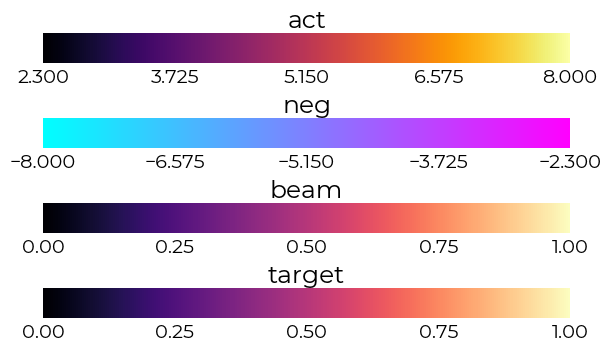

In [97]:
# read prf estimates
prf_dir = opj(deriv, "prf", subject, "ses-1")
pyc = pycortex.SavePycortexViews(
    {
        "act": z1_pos_v,
        "neg": z2_neg_v,
        "beam": beam_v,
        "target": target_v
    },
    subject=subject,
    radius=240,
    azimuth=200,
    altitude=118,
    pivot=0,
    clicker="plot",
    transpose=True,
    prf_file=opj(prf_dir, f"{subject}_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl"),
    func_data=opj(prf_dir, f"{subject}_ses-1_task-2R_hemi-LR_desc-avg_bold.npy"),
    dm=opj(prf_dir, "design_task-2R.mat"),
    rh=0,
    verbose=False)

saving act
saving neg
saving beam
saving target
saving /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/feat/level2/sub-008_desc-level1_confs.gfeat/sub-008_desc-brainmaps.pdf


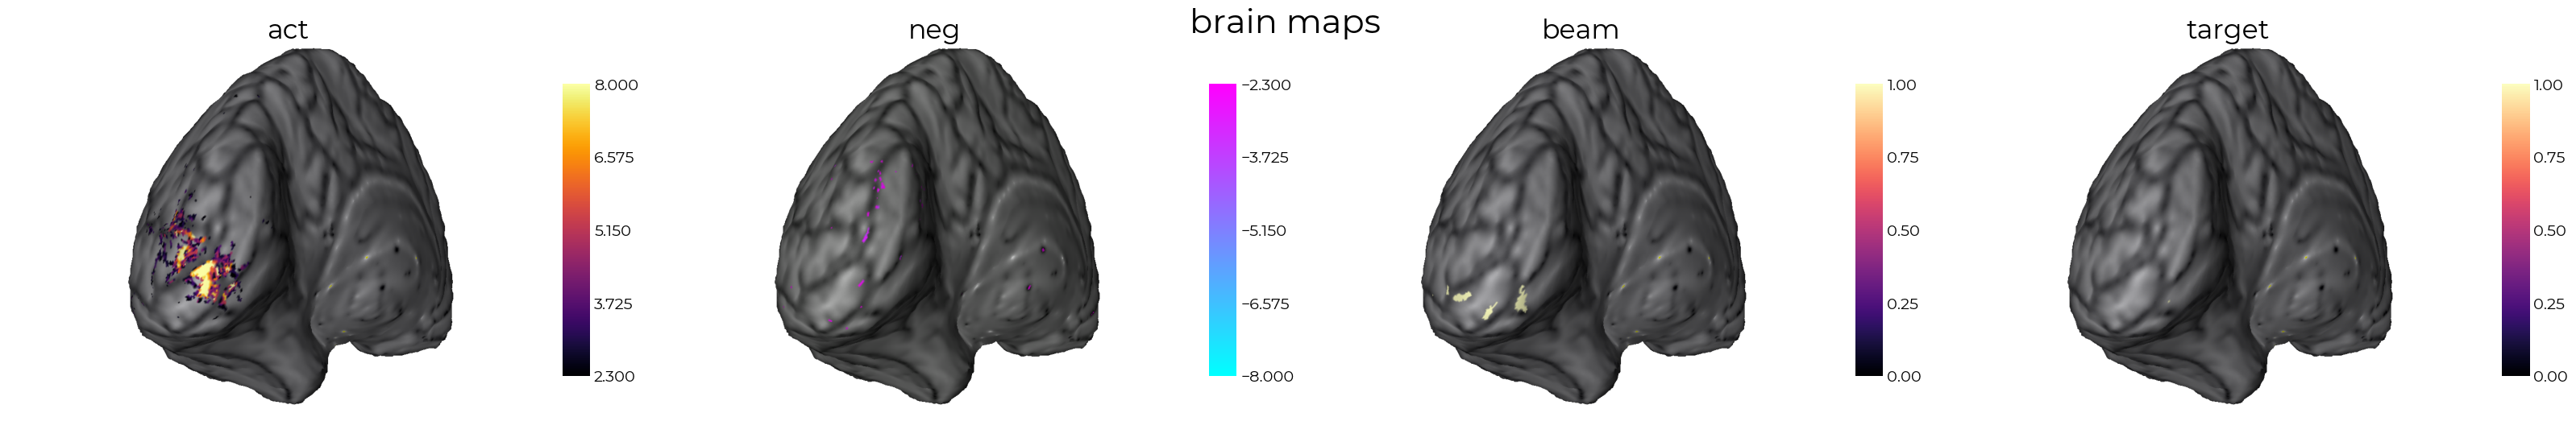

In [101]:
pyc.save_all(
    fig_dir=os.path.dirname(zstats[0]),
    gallery=True,
    add_cms=True,
    n_cols=4,
    cb=[200,1000,350,1500]
)

In [49]:
%matplotlib
pyc.fig

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>

### check motion parameters

ANTs estimates

In [13]:
motion_pars2 = np.loadtxt(f"/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/{subject}/ses-2/func/{subject}_ses-2_task-SRFi_run-1_acq-3DEPI_desc-motionpars.txt")
motion_pars2.shape

(306, 6)

Text(0.5, 0.98, 'antsMotionCorr (normalized to SPM convention)')

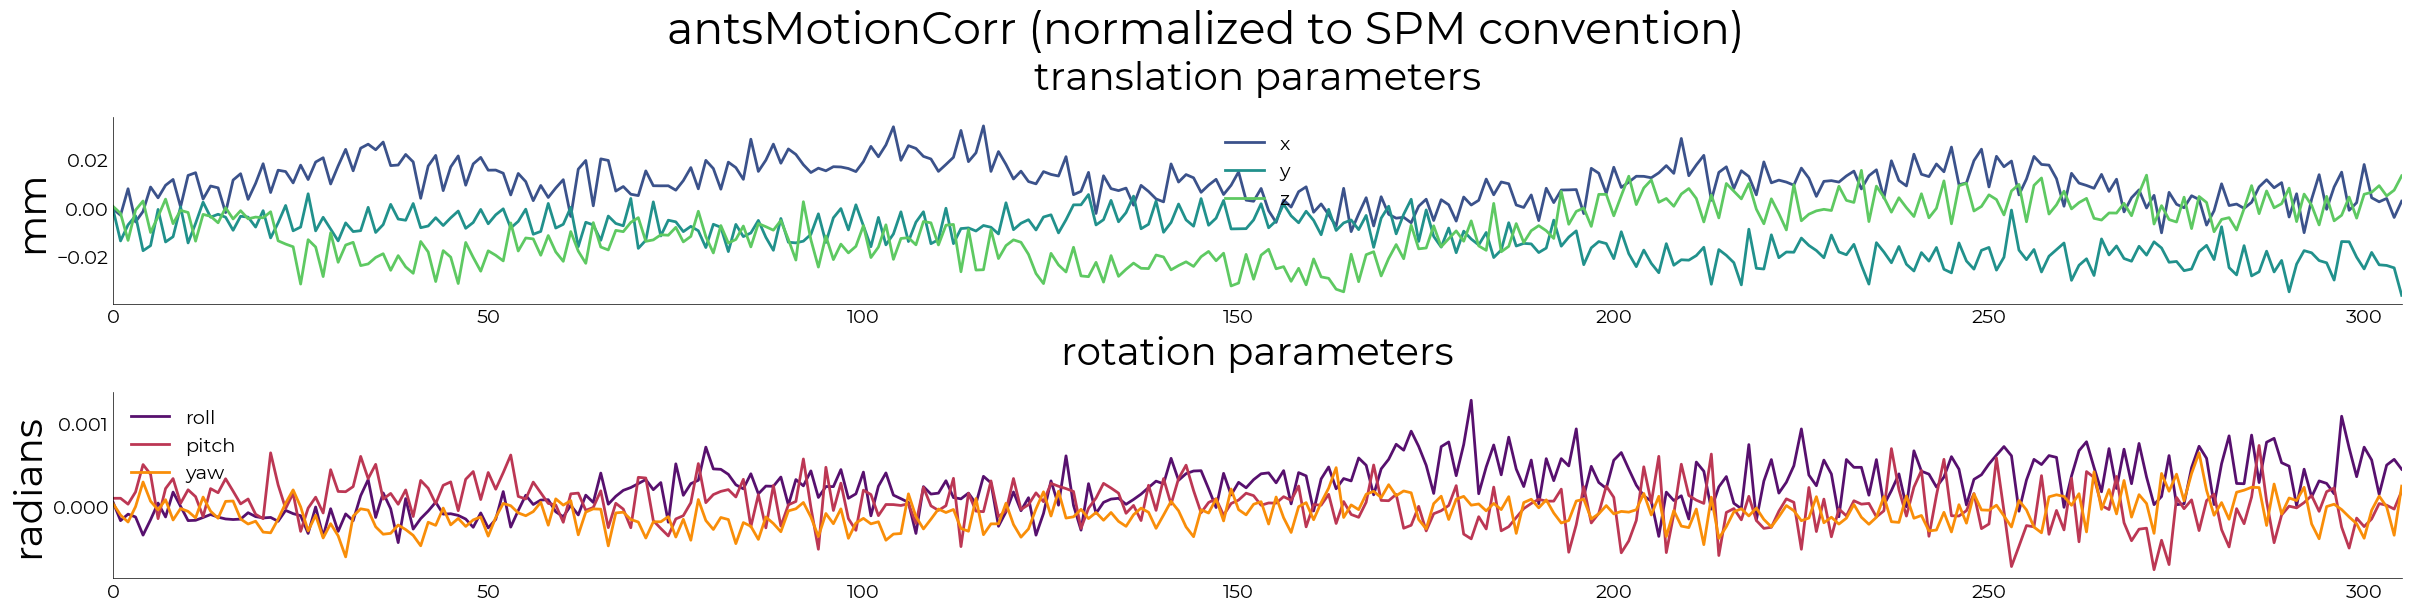

In [14]:
%matplotlib inline
fig,axs = plt.subplots(nrows=2, figsize=(24,6), constrained_layout=True)
plotting.LazyPlot(
    [motion_pars2[:,i] for i in range(3)],
    labels=["x","y","z"],
    line_width=2,
    axs=axs[0],
    title="translation parameters",
    y_label="mm",
    font_size=28,
)

plotting.LazyPlot(
    [motion_pars2[:,i+3] for i in range(3)],
    labels=["roll","pitch","yaw"],
    cmap="inferno",
    line_width=2,
    axs=axs[1],
    title="rotation parameters",
    y_label="radians",
    font_size=28,
    # y_lim=[-.4,.4]
)
fig.suptitle("antsMotionCorr (normalized to SPM convention)", fontsize=32)

McFlirt estimates

Text(0.5, 0.98, 'McFlirt')

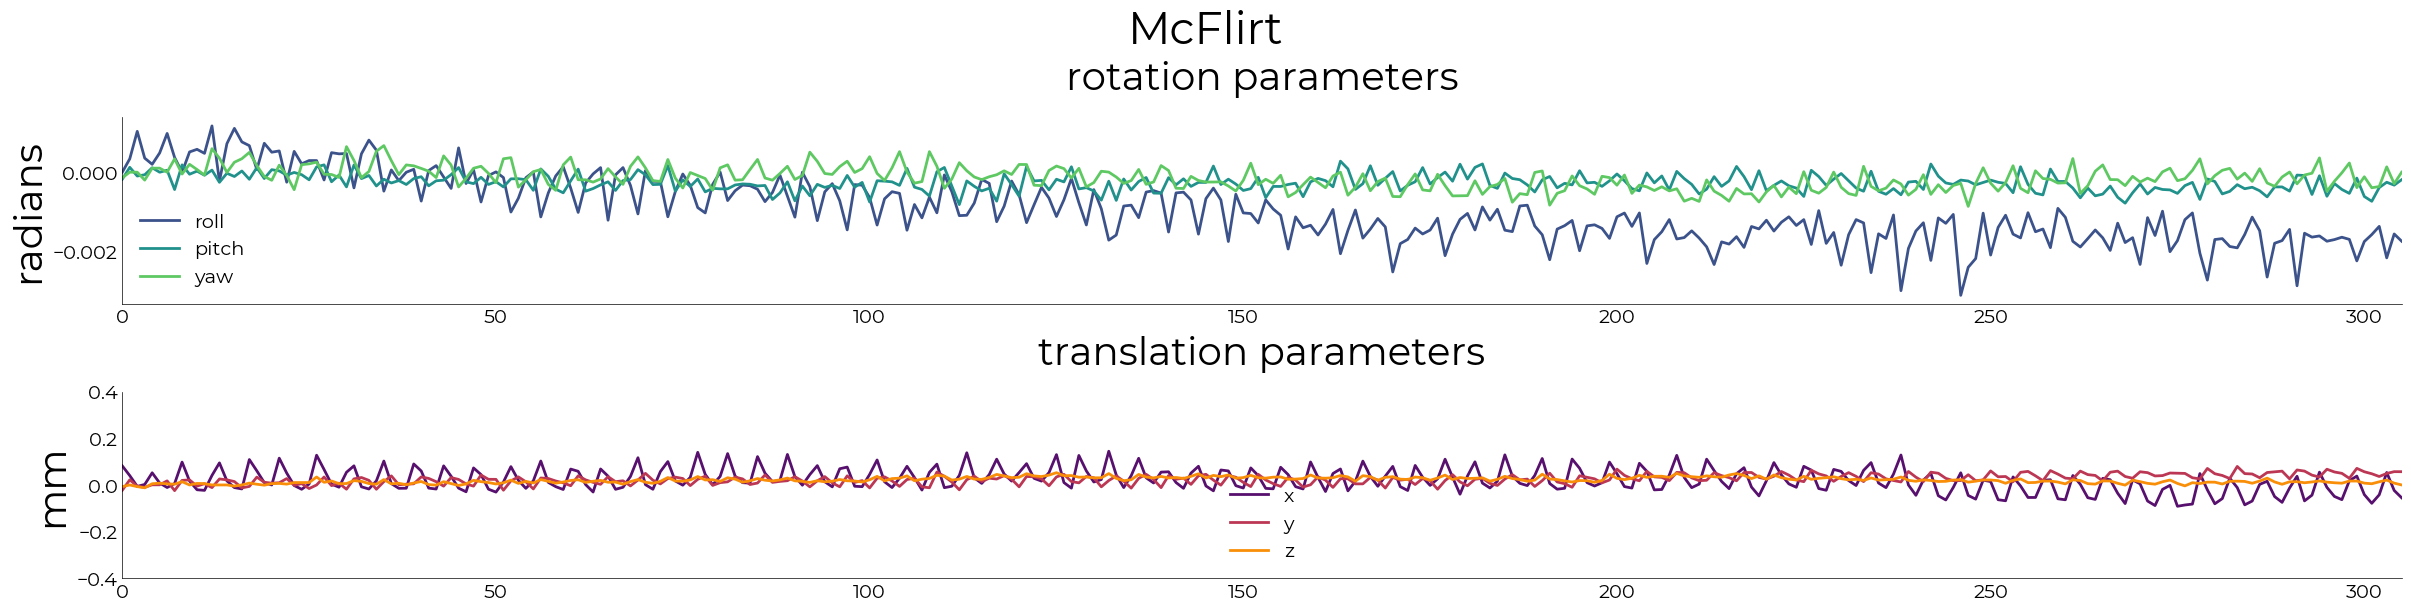

In [150]:
motion_pars = np.loadtxt("/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/sourcedata/sub-008/ses-2/single_subject_008_wf/func_preproc_ses_2_task_SRFi_run_1_acq_3DEPI_wf/bold_hmc_wf/mcflirt/sub-008_ses-2_task-SRFi_run-1_acq-3DEPI_bold_valid_mcf.nii.gz.par")

fig,axs = plt.subplots(nrows=2, figsize=(24,6), constrained_layout=True)
plotting.LazyPlot(
    [motion_pars[:,i] for i in range(3)],
    labels=["roll","pitch","yaw"],
    line_width=2,
    axs=axs[0],
    title="rotation parameters",
    y_label="radians",
    font_size=28
)

plotting.LazyPlot(
    [motion_pars[:,i+3] for i in range(3)],
    labels=["x","y","z"],
    cmap="inferno",
    line_width=2,
    axs=axs[1],
    title="translation parameters",
    y_label="mm",
    font_size=28,
    y_lim=[-.4,.4]
)

fig.suptitle("McFlirt", fontsize=32)

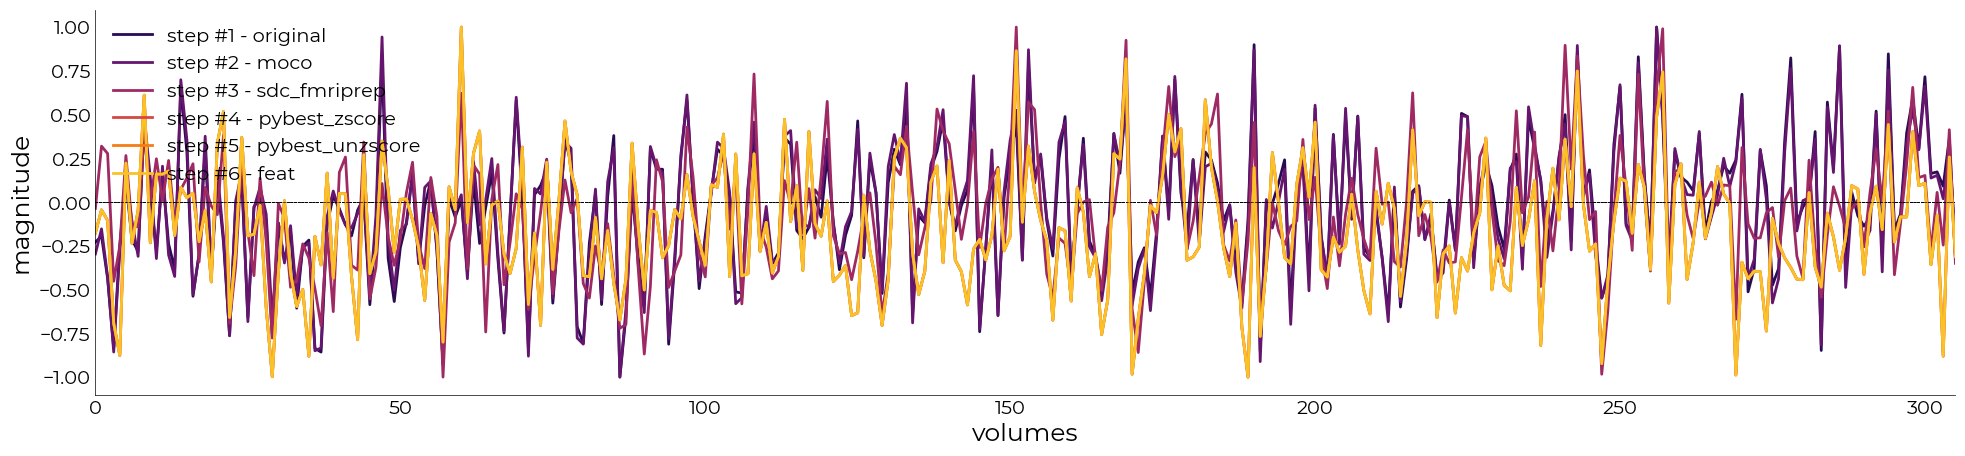

In [52]:
import seaborn as sns
tc_steps = np.loadtxt("/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/sub-008/sub-008_step-all_desc-timecourses.txt")

steps = {
    "1": "original",
    "2": "moco",
    "3": "sdc_fmriprep",
    "4": "pybest_zscore",
    "5": "pybest_unzscore",
    "6": "feat"
}

cols = sns.color_palette("inferno", tc_steps.shape[-1])
fig,axs = plt.subplots(figsize=(24,5))
for step,name in steps.items():
    ix = int(step)-1
    plotting.LazyPlot(
        tc_steps[:,ix],
        labels=[f"step #{step} - {name}"],
        line_width=2,
        axs=axs,
        color=cols[ix],
        x_label="volumes",
        y_label="magnitude",
        add_hline=0
    )

## GLM

In [44]:
from linescanning import preproc
try:
    hp_data = utils.select_from_df(renamed_func, expression="run = 1")
except:
    hp_data = renamed_func.copy()

hp_lp_data = preproc.lowpass_savgol(
    hp_data.squeeze(),
    window_length=41,
    polyorder=3
)

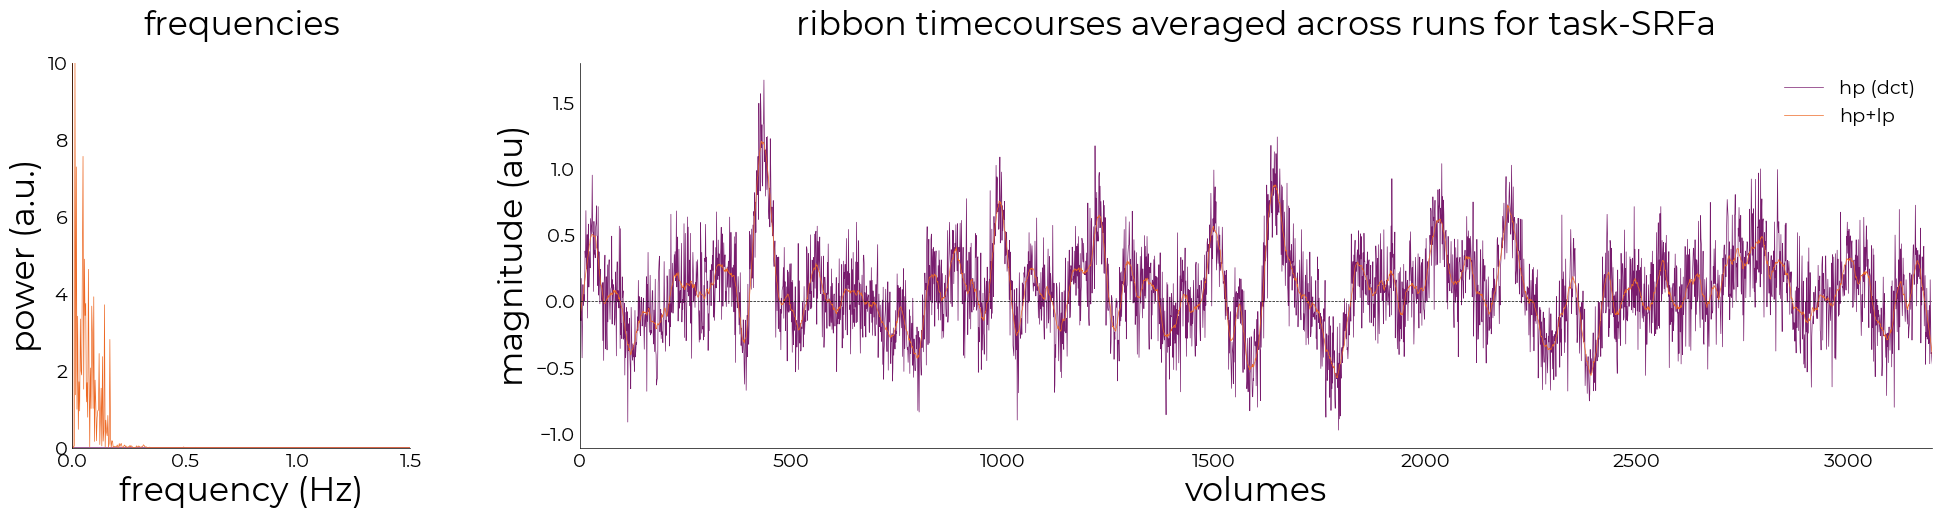

In [47]:

# collect power spectra
freqs = []
tcs = [hp_data,hp_lp_data]
lbls = ["hp (dct)", "hp+lp"]
for tc in tcs:

    # freq
    tc_freq = preproc.get_freq(tc, TR=0.105, spectrum_type='fft')

    # append
    freqs.append(tc_freq)         

# create figure
fig,axs = plt.subplots(ncols=2, figsize=(24,5), gridspec_kw={"width_ratios": [0.2,0.8]})
colors = ["#cccccc","r"]
lws = 0.5
fs = 24

plotting.LazyPlot(
    [freqs[ii][1] for ii in range(len(tcs))],
    xx=freqs[0][0],
    x_label="frequency (Hz)",
    y_label="power (a.u.)",
    title="frequencies",
    axs=axs[0],
    x_lim=[0,1.5],
    line_width=lws,
    font_size=fs,
    # color=colors,
    cmap="inferno",
    y_lim=[0,10]) 


# plot timecourses
plotting.LazyPlot(
    tcs,
    axs=axs[1],
    x_label="volumes",
    y_label="magnitude (au)",
    font_size=fs,
    # add_hline=0,
    line_width=lws,
    # color=colors,
    cmap="inferno",
    labels=lbls,
    add_hline=0,
    title=f"ribbon timecourses averaged across runs for task-SRFa"
)

In [48]:
c_vec1 = [0,1,1,0,0]
c_vec2 = [0,0,0,1,1]
c_vec3 = [0,1,1,1,1]

c_vec = np.array([c_vec1,c_vec2,c_vec3])
c_vec.shape

(3, 5)

In [49]:
try:
    active_onsets = utils.select_from_df(renamed_onsets, expression="run = 1")
except:
    active_onsets = renamed_onsets
active_onsets.head()

onset
subject run event_type           
002     1   norm        30.439581
            act         39.589321
            norm        47.339293
            norm        54.381006
            norm        61.705944

### GLM - high-passed data (DCT)

In [50]:
fitter = glm.GenericGLM(
    active_onsets,
    hp_data,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0.]: [23.75366716]
t-stat [0. 0. 0. 1. 1.]: [11.77673197]
t-stat [0. 1. 1. 1. 1.]: [22.5628379]


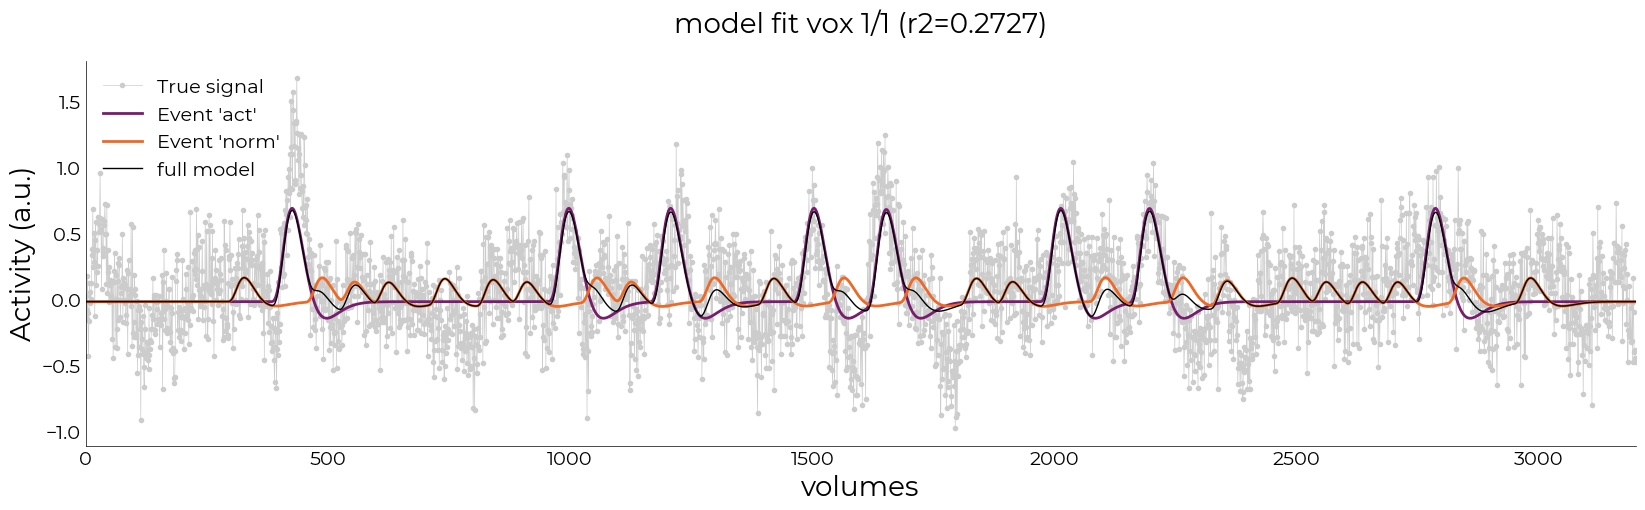

In [51]:
fitter.create_design()
fitter.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)
t_pre = fitter.results["tstats"]

### GLM - high+low-pass data

In [52]:
fitter_lp = glm.GenericGLM(
    active_onsets, 
    hp_lp_data,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0.]: [36.12495803]
t-stat [0. 0. 0. 1. 1.]: [17.6368676]
t-stat [0. 1. 1. 1. 1.]: [34.18066098]


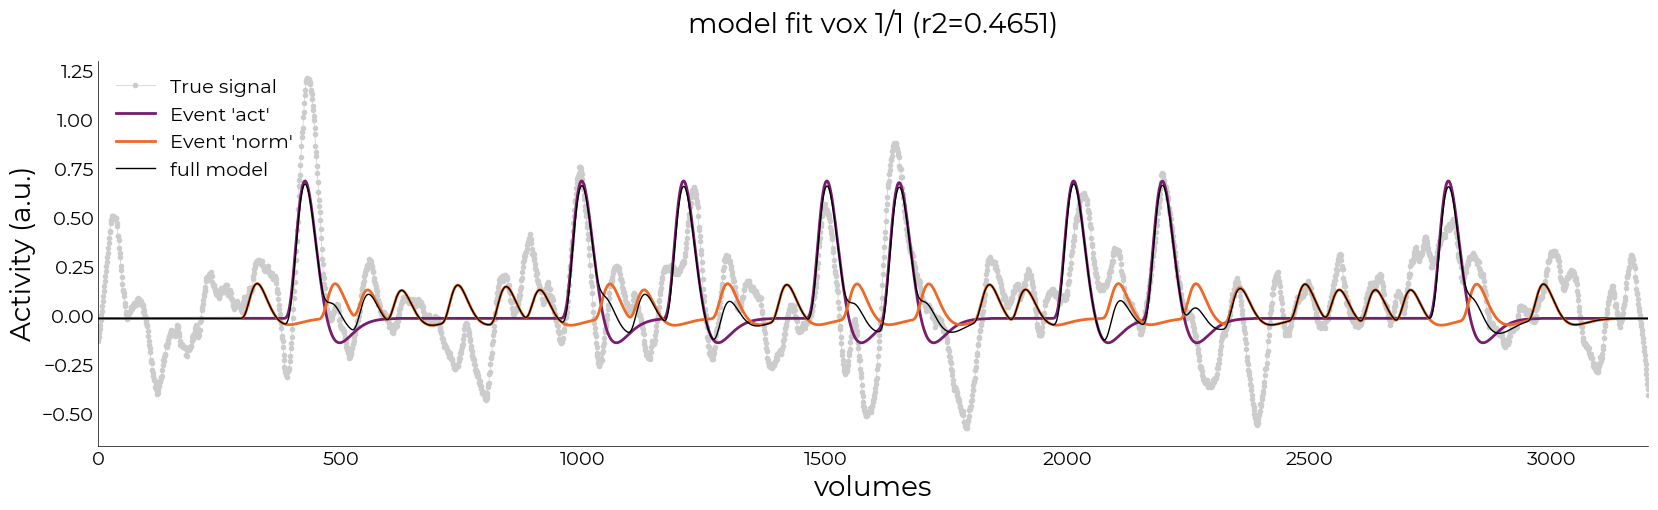

In [53]:
fitter_lp.create_design()
fitter_lp.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)
t_lp = fitter_lp.results["tstats"]

### GLM - ribbon data

In [54]:
try:
    df_rib = utils.select_from_df(df_ribbon, expression="task = SRFa")
except:
    df_rib = df_ribbon.copy()
df_rib.head()

vox 360   vox 361   vox 362   vox 363   vox 364   vox 365  \
subject t                                                                   
002     0.000  0.213488 -0.718330  0.440727  0.018664 -0.138749  0.094931   
        0.105 -0.262278 -0.439606  0.303754  0.003279 -0.254687 -0.345201   
        0.210 -0.035692 -0.018689 -0.163128 -0.079506 -0.453055  0.285292   
        0.315 -0.414393 -0.244478 -0.201566 -0.278917  0.024515 -0.390553   
        0.420 -0.345463  0.021505  0.020318  0.426147  0.067006  0.364578   

                vox 366   vox 367   vox 368  
subject t                                    
002     0.000 -0.014397  0.555425 -0.225076  
        0.105 -0.004276  0.267479  0.089727  
        0.210 -0.330980 -0.217049  0.308846  
        0.315  0.109900  0.246156 -0.175924  
        0.420  0.144934  0.464448  0.386084

In [55]:
fit_rib = glm.GenericGLM(
    active_onsets, 
    df_rib,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


t-stat [0. 1. 1. 0. 0.]: [13.53007905 13.59332092 17.30260272 14.69548372 16.12220428 15.66085706
 16.8707798  16.43199383 16.59890166]
t-stat [0. 0. 0. 1. 1.]: [7.1647498  8.1393933  8.0793132  8.20497059 8.21633409 7.50738042
 6.45148196 7.56446309 8.33911875]
t-stat [0. 1. 1. 1. 1.]: [13.07442872 13.59433409 16.19189359 14.40683373 15.42275129 14.75043312
 15.09255013 15.32436507 15.82019488]


(3, 9)

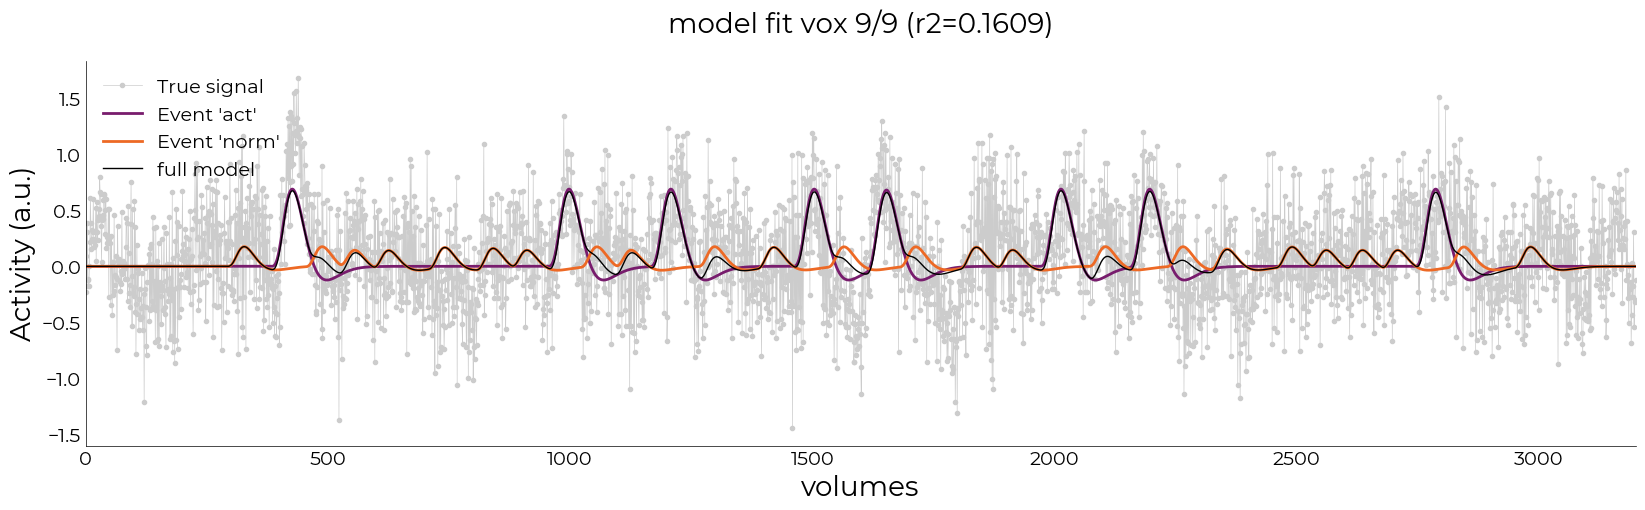

In [56]:
fit_rib.create_design()
fit_rib.fit(
    make_figure=True, 
    copes=c_vec, 
    verbose=True, 
    plot_full=True)

t_rib = fit_rib.results["tstats"]
t_rib.shape

In [58]:
ddict = {}
t_ = []
i_ = []
v_ = []
d_ = []
c_ = []
i_name = []
for ix,tag in enumerate(["act","norm","full"]):
    t_.append(t_rib[ix,:])
    i_.append(np.full(t_rib.shape[1],ix))
    c_.append(np.full(t_rib.shape[1],str(tag), dtype=object))
    v_.append(np.arange(0,t_rib.shape[1]))
    d_.append([round(ii,2) for ii in np.arange(0,t_rib.shape[1])/(t_rib.shape[1]-1)*100])

ddict["tstat"] = np.concatenate(t_)
ddict["contrast_ix"] = np.concatenate(i_)
ddict["contrast"] = np.concatenate(c_)
ddict["voxel"] = np.concatenate(v_)
ddict["depth"] = np.concatenate(d_)

df_t = pd.DataFrame(ddict)
df_t.head()

tstat  contrast_ix contrast  voxel  depth
0  13.530079            0      act      0    0.0
1  13.593321            0      act      1   12.5
2  17.302603            0      act      2   25.0
3  14.695484            0      act      3   37.5
4  16.122204            0      act      4   50.0

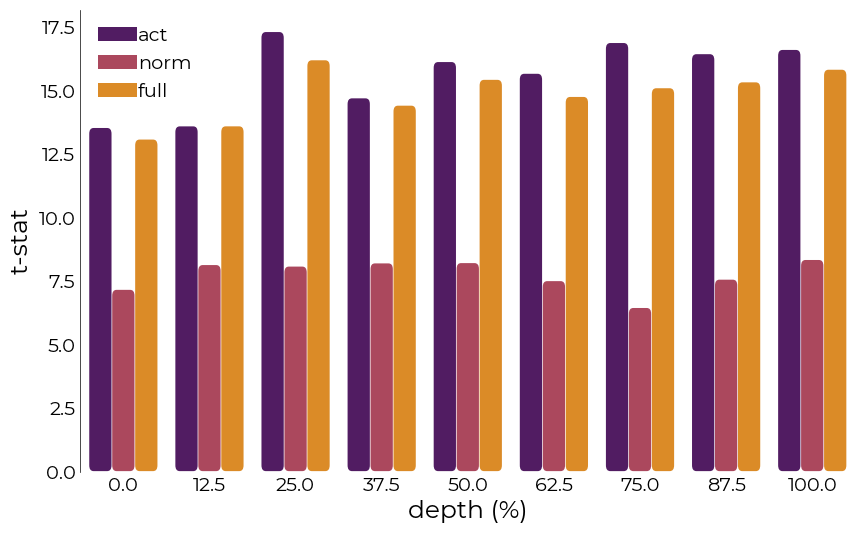

In [59]:
plotting.LazyBar(
    data=df_t,
    x="depth",
    y="tstat",
    hue="contrast",
    sns_ori="v",
    error=None,
    figsize=(10,6),
    fancy=True,
    fancy_rounding=0.05,
    fancy_denom=4,
    add_labels=True,
    x_label2="depth (%)",
    y_label2="t-stat",
    bar_legend=True
)

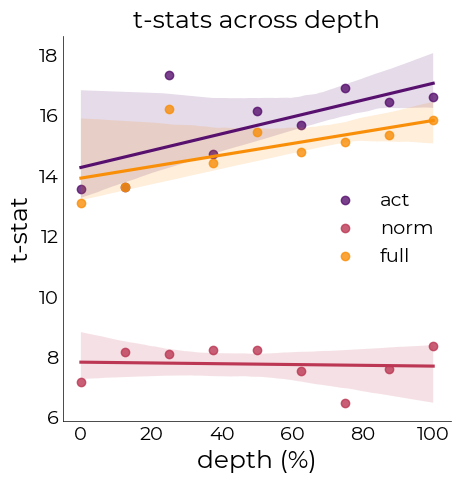

In [64]:
import seaborn as sns
fig,axs = plt.subplots(figsize=(5,5))

colors = sns.color_palette("inferno", 3)
for ix,tag in enumerate(["act","norm","full"]):
    pl = plotting.LazyCorr(
        d_[ix],
        t_rib[ix,:],
        axs=axs,
        color=colors[ix],
        label=tag,
        x_label="depth (%)",
        y_label="t-stat",
        title="t-stats across depth",
)

axs.legend(frameon=False, fontsize=pl.label_size)

### GLM - full line

In [28]:
try:
    df_avg_filt = df_filt.groupby(["subject","task","t"]).mean()
    df_line = utils.select_from_df(df_avg_filt, expression=f"task = SRFa")
except:
    df_line = df_filt.groupby(["subject", "t"]).mean()
df_line.head()

vox 0     vox 1     vox 2     vox 3     vox 4     vox 5  \
subject t                                                                   
002     0.000  2.176804 -0.410821 -1.439025 -1.155998  3.010995 -5.030360   
        0.105  3.914322  0.436195 -5.219850 -5.813075 -3.785418 -9.796140   
        0.210  4.586998 -1.202501 -6.010672 -1.613623  1.886084 -0.723502   
        0.315 -7.666696  2.347750 -3.973495 -2.114871  0.521385  0.626828   
        0.420 -7.470938 -5.768045 -1.227380  1.833694 -3.444798  4.067503   

                  vox 6     vox 7     vox 8     vox 9  ...    vox 710  \
subject t                                              ...              
002     0.000 -0.269224 -7.284733  4.974844 -1.119031  ...   8.918236   
        0.105 -0.770855 -0.139402  0.248894  4.882230  ...  -2.804108   
        0.210  1.372732  3.035108  6.238840 -2.993182  ...   7.077477   
        0.315  8.254901 -0.660950  3.022396  5.771118  ...  -2.941053   
        0.420 -2.689762 -0.051336  1.366962  2.184457  ... -20.843452   

                vox 711    vox 712   vox 713   vox 714   vox 715   vox 716  \
subject t                                                                    
002     0.000  5.761827   1.255807 -2.351180 -6.691586  2.751714  2.377349   
        0.105  0.125778   9.381156  2.591207 -9.496345 -4.932249  1.872609   
        0.210  4.384428   1.750137  7.577517 -1.210955  1.056587 -3.290504   
        0.315 -8.745996  10.164702 -9.844546 -7.217720  0.078747 -6.452597   
        0.420 -4.313631   2.312692 -5.685273  0.716042 -0.892830  8.704746   

                vox 717    vox 718   vox 719  
subject t                                     
002     0.000 -0.792393  -1.297432  0.122362  
        0.105  0.811598  -7.080044  9.745252  
        0.210 -5.207760   1.404495  7.142429  
        0.315 -0.451956 -14.988744 -7.093969  
        0.420 -0.260895  14.034713 -5.027051  

[5 rows x 720 columns]

In [29]:
fit_line = glm.GenericGLM(
    active_onsets, 
    df_line,
    hrf_pars="glover",
    derivative=True,
    TR=0.105, 
    osf=100, 
    verbose=True)

Defining HRF with option 'glover'
Creating stimulus vector(s)
Convolve stimulus vectors with HRF
Resample convolved stimulus vectors


(3, 720)

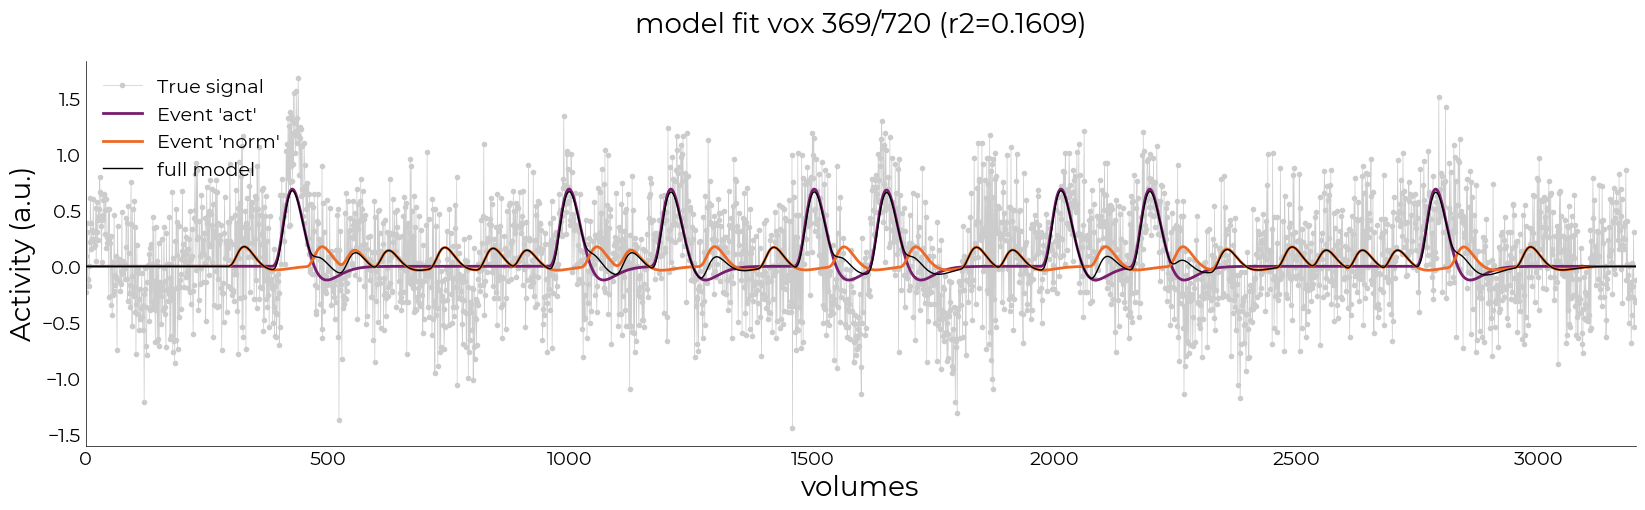

In [30]:
fit_line.create_design()
fit_line.fit(
    make_figure=True, 
    copes=c_vec, 
    # verbose=True, 
    plot_full=True)

t_line = fit_line.results["tstats"]
t_line.shape

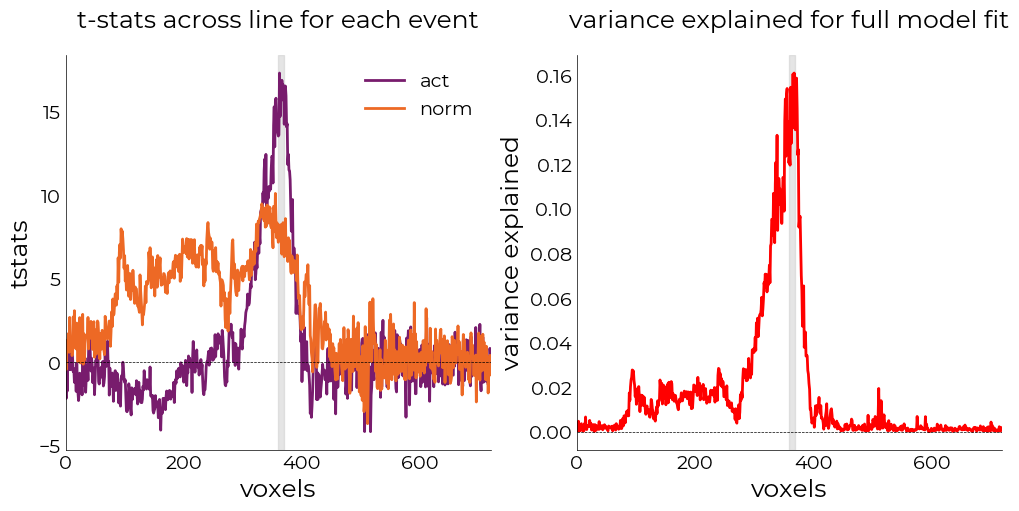

In [72]:
fig,axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
plotting.LazyPlot(
    [t_line[i] for i,_ in enumerate(fit_line.plot_event)],
    axs=axs[0],
    x_label="voxels",
    y_label="tstats",
    labels=fit_line.plot_event,
    line_width=2,
    cmap="inferno",
    add_hline=0,
    title="t-stats across line for each event"
)

plotting.LazyPlot(
    fit_line.results["r2"],
    axs=axs[1],
    x_label="voxels",
    y_label="variance explained",
    line_width=2,
    color="r",
    title="variance explained for full model fit",
    add_hline=0
)

for ax in axs:
    ax.axvspan(*ribbon, alpha=0.5, color="#cccccc")

In [265]:
class CorrelationPlotter():

    def __init__(
        self, 
        slice_file: str=None,
        stats_file: str=None,
        beam_file: str=None,
        mask_file: str=None,
        line_stats: np.ndarray=None,
        t_thr: float=2.3,
        vmax=7,
        **kwargs):

        self.slice_file = slice_file
        self.stats_file = stats_file
        self.beam_file = beam_file
        self.mask_file = mask_file
        self.t_thr = t_thr
        self.line_stats = line_stats
        self.vmax = vmax

        # read files into numpy arrays
        for tag,ff in zip(
            ["slice", "stats", "beam", "mask"],
            [self.slice_file, self.stats_file, self.beam_file, self.mask_file]):

            img = np.rot90(nb.load(ff).get_fdata())
            setattr(self, f"{tag}_img", img)

        # get arrays for positive and negative t-stats
        self.t_pos, self.t_neg = self._split_stat_array(thr=self.t_thr)

        # prepare bunch of colormaps
        for i,tag,func in zip(
            ["cm_beam", "cm_mask", "cm_pos", "cm_neg"], 
            ["red", "white", "pos", "neg"],
            [utils.make_binary_cm,utils.make_binary_cm,utils.make_stats_cm,utils.make_stats_cm]):
            
            # make colormap
            cm = func(tag)
            setattr(self,i,cm)

    def plot_images(self, axs=None, figsize=(8,8), **kwargs):
        if not axs:
            fig,self.img_axs = plt.subplots(figsize=figsize)
        else:
            self.img_axs = axs

        self.img_axs.imshow(self.slice_img, cmap="gray")
        self.img_axs.imshow(self.beam_img, cmap=self.cm_beam, alpha=0.4)
        self.img_axs.imshow(self.t_pos, cmap=self.cm_pos, vmin=self.t_thr, vmax=self.vmax)
        self.img_axs.imshow(self.t_neg, cmap=self.cm_neg, vmin=self.t_thr, vmax=self.vmax)

        plotting.conform_ax_to_obj(ax=self.img_axs)
        self.img_axs.axis("off")

    def _split_stat_array(self, thr=2.3):

        # positive
        stats_pos = np.full_like(self.stats_img, np.nan)
        stats_pos[self.stats_img>thr] = stats_img[self.stats_img>thr]

        # negative, but make absolute so plotting is easier
        stats_neg = np.full_like(self.stats_img, np.nan)
        stats_neg[self.stats_img<-thr] = abs(stats_img[stats_img<-thr])

        return stats_pos,stats_neg

    def plot_tstat_correlation(
        self,
        axs=None,
        figsize=(6,6),
        **kwargs):

        if not axs:
            self.fig,self.corr_axs = plt.subplots(figsize=figsize)
        else:
            self.corr_axs = axs

        # brain mask slice/line to get relevant voxels
        self.mask_beam = self.mask_img[np.where(self.beam_img.squeeze()>0)].reshape((16,720)).mean(axis=0)
        self.line_idc = np.where(self.mask_beam>0.95)[0]

        # for each relevant voxel, get the distance in mm to the target; red is further to the right, blue is further to the left
        self.dist_to_targ = [(i-self.beam_img.shape[0]//2)*0.25 for i in self.line_idc]

        # fetch stats in beam space
        self.stats_in_line = self.stats_img[np.where(self.beam_img.squeeze()>0)].reshape((16,720)).mean(axis=0)

        # plot t-stats from line vs 3D-EPI
        self.corr = plotting.LazyCorr(
            x=self.line_stats[line_idc],
            y=self.stats_in_line[line_idc],
            axs=self.corr_axs,
            x_label="t-stats line",
            y_label="t-stats 3D-EPI",
            color_by=self.dist_to_targ,
            **kwargs)      

In [266]:
slice_file = opj(
    os.environ.get("DIR_DATA_HOME"), 
    subject, 
    "ses-2", 
    "anat", 
    f"{subject}_ses-2_task-SRFa_run-1_acq-1slice_T1w.nii.gz")

stats_file = opj(
    os.environ.get("DIR_DATA_DERIV"), 
    "feat", 
    "level2", 
    f"{subject}_desc-level1.gfeat", 
    "cope1.feat", 
    "stats", 
    "tstat1_space-line.nii.gz")

beam_file = opj(
    os.environ.get("DIR_DATA_HOME"), 
    subject, 
    "ses-2", 
    "func", 
    f"{subject}_ses-2_task-SRFa_run-1_bold.nii.gz")

mask_file = opj(
    os.path.dirname(stats_file),
    "mask_space-line.nii.gz"
)

obj_ = CorrelationPlotter(
    slice_file=slice_file,
    stats_file=stats_file,
    beam_file=beam_file,
    mask_file=mask_file,
    line_stats=t_line[0]
)

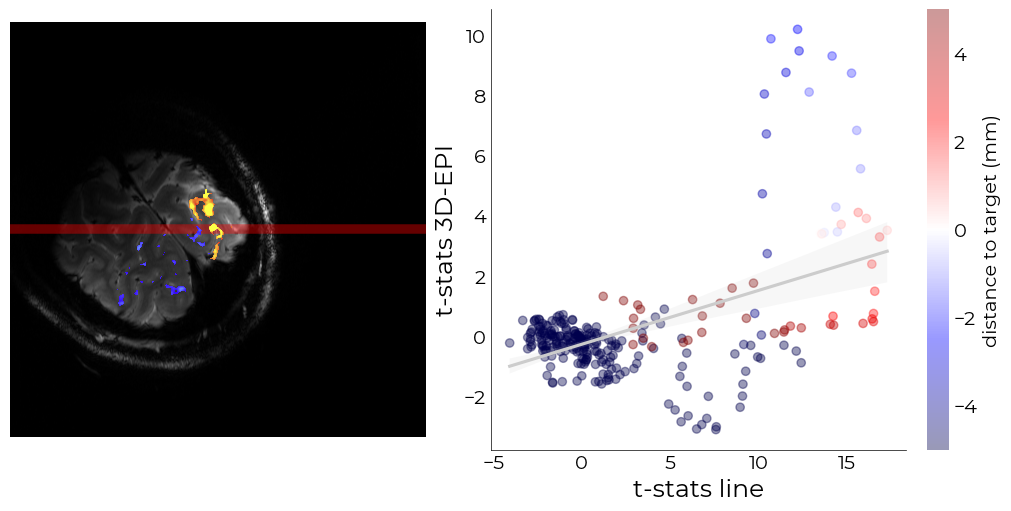

In [291]:
fig,axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
obj_.plot_images(axs=axs[0])
obj_.plot_tstat_correlation(
    axs=axs[1], 
    correlation=True,
    scatter_kwargs={
        "alpha": 0.4,
        "cmap": "seismic",
        "label": "distance to target (mm)",
        "vmin": -5,
        "vmax": 5}
    )

In [270]:
obj_.corr.correlation_result

X  Y   method alternative    n         r         CI95%         p-unc  \
0  x  y  pearson   two-sided  277  0.484962  [0.39, 0.57]  9.549202e-18   

        BF10  power  
0  5.928e+14    1.0

## Deconvolve

In [275]:
df_rib2 = df_rib.copy().reset_index()
df_rib2["run"] = 1
df_rib2 = df_rib2.set_index(["subject","run", "t"])
df_rib2.head()

vox 360   vox 361   vox 362   vox 363   vox 364   vox 365  \
subject run t                                                                   
002     1   0.000  0.213488 -0.718330  0.440727  0.018664 -0.138749  0.094931   
            0.105 -0.262278 -0.439606  0.303754  0.003279 -0.254687 -0.345201   
            0.210 -0.035692 -0.018689 -0.163128 -0.079506 -0.453055  0.285292   
            0.315 -0.414393 -0.244478 -0.201566 -0.278917  0.024515 -0.390553   
            0.420 -0.345463  0.021505  0.020318  0.426147  0.067006  0.364578   

                    vox 366   vox 367   vox 368  
subject run t                                    
002     1   0.000 -0.014397  0.555425 -0.225076  
            0.105 -0.004276  0.267479  0.089727  
            0.210 -0.330980 -0.217049  0.308846  
            0.315  0.109900  0.246156 -0.175924  
            0.420  0.144934  0.464448  0.386084

In [315]:
# fit events on averaged data
can_fit = fitting.NideconvFitter(
    df_rib2,
    active_onsets, 
    basis_sets='canonical_hrf_with_time_derivative',
    # n_regressors=4,
    TR=0.105,
    interval=[-3,25],
    add_intercept=True,
    verbose=True,
    fit=True)

# fit events on averaged data
fou_fit = fitting.NideconvFitter(
    df_rib2,
    active_onsets, 
    basis_sets='fourier',
    n_regressors=2,
    TR=0.105,
    interval=[-3,25],
    add_intercept=True,
    verbose=True,
    fit=True)


Converting dtype of onsets to int64...


Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event 'act' to model
Adding event 'norm' to model
Fitting with 'ols' minimization
Done


Converting dtype of onsets to int64...


Selected 'fourier'-basis sets
Adding event 'act' to model
Adding event 'norm' to model
Fitting with 'ols' minimization
Done


In [316]:
# # fit button response on single run data
# response_onsets = utils.select_from_df(df_onsets, expression="event_type = response")
# fit_button = fitting.NideconvFitter(
#     df_func,
#     response_onsets,
#     basis_sets='fourier',
#     n_regressors=9,
#     TR=0.105,
#     interval=[-3,17],
#     add_intercept=True,
#     verbose=True,
#     fit=True)

# fit_button.timecourses_condition()

## Plotting

### Average over ribbon voxels

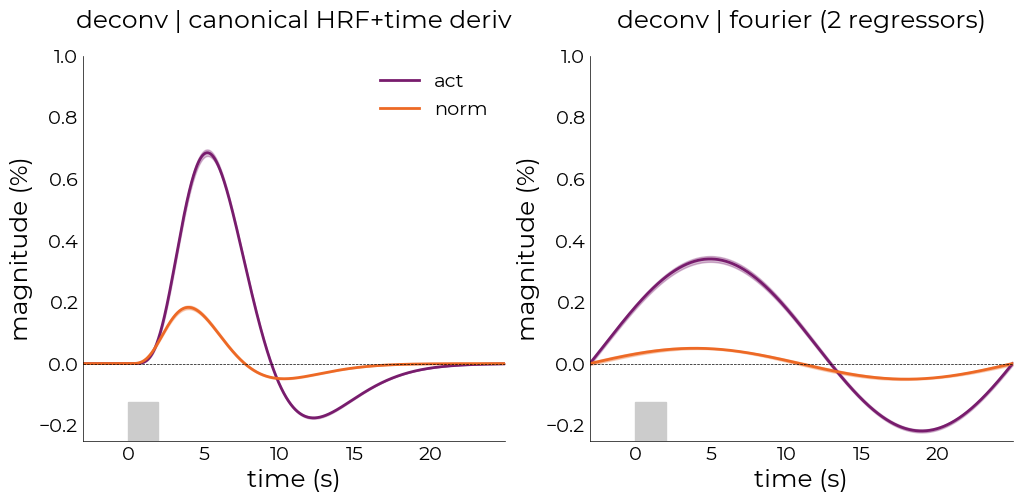

In [317]:
%matplotlib inline
fig,axs = plt.subplots(ncols=2, figsize=(12,5))

y_lim = [-0.25,1]
can_fit.plot_average_per_event(
    x_label="time (s)",
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs[0],
    title="deconv | canonical HRF+time deriv",
    labels=can_fit.cond,
    line_width=2,
    cmap='inferno',
    y_lim=y_lim)

fou_fit.plot_average_per_event(
    x_label="time (s)",
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs[1],
    title=f"deconv | fourier ({fou_fit.n_regressors} regressors)",
    line_width=2,
    cmap='inferno',
    y_lim=y_lim)

# plot stimulus onset
for ax in axs:
    ax.axvspan(0,2, ymax=0.1, color="#cccccc")

In [293]:
can_fit.predictions.head()

vox 360   vox 361  vox 362   vox 363   vox 364   vox 365  \
subject run t                                                                  
002     1   0.000 -0.005393 -0.056148 -0.01935 -0.002984  0.008203  0.031165   
            0.105 -0.005393 -0.056148 -0.01935 -0.002984  0.008203  0.031165   
            0.210 -0.005393 -0.056148 -0.01935 -0.002984  0.008203  0.031165   
            0.315 -0.005393 -0.056148 -0.01935 -0.002984  0.008203  0.031165   
            0.420 -0.005393 -0.056148 -0.01935 -0.002984  0.008203  0.031165   

                    vox 366   vox 367   vox 368  
subject run t                                    
002     1   0.000  0.040464  0.001724  0.021336  
            0.105  0.040464  0.001724  0.021336  
            0.210  0.040464  0.001724  0.021336  
            0.315  0.040464  0.001724  0.021336  
            0.420  0.040464  0.001724  0.021336

In [321]:
# individual model fits
fit_objs = []
for ii in can_fit.cond:

    nd_ = fitting.NideconvFitter(
        df_rib2,
        utils.select_from_df(df_onsets, expression=f"event_type = {ii}"),
        basis_sets='canonical_hrf_with_time_derivative',
        TR=0.105,
        interval=[-3,25],
        add_intercept=True,
        verbose=True)

    nd_.timecourses_condition()
    fit_objs.append(nd_)

Converting dtype of onsets to int64...


Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event 'act' to model
Fitting with 'ols' minimization
Done


Converting dtype of onsets to int64...


Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event 'norm' to model
Fitting with 'ols' minimization
Done


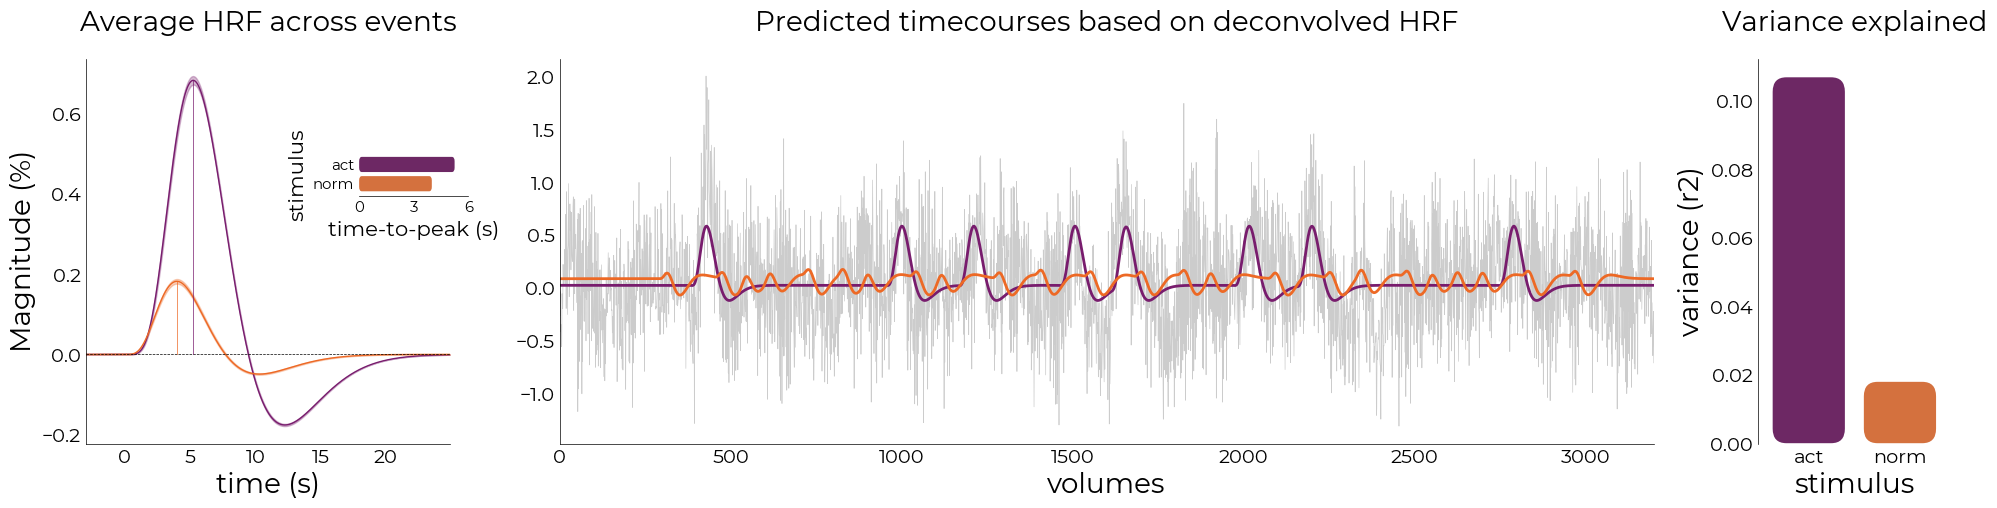

In [322]:
from sklearn.metrics import r2_score

fig = plt.figure(figsize=(24,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,3,0.5], wspace=0.2)
font_size = 20

ax1 = fig.add_subplot(gs[0])
can_fit.plot_average_per_event(
    axs=ax1,
    x_label="time (s)",
    y_label="Magnitude (%)",
    add_hline='default',
    ttp=True,
    ttp_lines=True,
    add_labels=True,
    y_label2="stimulus",
    x_label2="time-to-peak (s)",
    ttp_labels=can_fit.cond,
    lim=[0, 6],
    ticks=[0,3,6],
    cmap='inferno',
    fancy=True,
    font_size=font_size)

ax2 = fig.add_subplot(gs[1])
colors = sns.color_palette('inferno', len(can_fit.cond))
preds = [utils.select_from_df(fit_objs[ii].predictions, expression="run = 1").iloc[:,0].values for ii in range(len(fit_objs))]
real = utils.select_from_df(df_rib2, expression="run = 1").iloc[:, 0].values

plotting.LazyPlot(
    [ii for ii in [real]+preds],
    line_width=[0.5]+[2 for ii in range(len(fit_objs))],
    color=["#cccccc"]+colors,
    axs=ax2,
    title="Predicted timecourses based on deconvolved HRF",
    font_size=font_size,
    x_label="volumes")

# calculate r2's
ax3 = fig.add_subplot(gs[2])
r2s = [r2_score(real, preds[ii]) for ii in range(len(fit_objs))]
plotting.LazyBar(
    x=can_fit.cond,
    y=r2s,
    palette=colors,
    sns_ori="v",
    axs=ax3,
    add_labels=True,
    x_label2="stimulus",
    y_label2="variance (r2)",
    font_size=font_size,
    title2="Variance explained",
    fancy_denom=4,
    sns_offset=4,
    error=None,
    fancy=True)


In [323]:
can_fit.model.get_rsq()

vox 360   vox 361   vox 362   vox 363   vox 364  vox 365  \
subject run                                                              
002     1    0.122729  0.119124  0.151913  0.127544  0.142079  0.13359   

             vox 366   vox 367   vox 368  
subject run                               
002     1    0.15727  0.133634  0.158426

In [324]:
fou_fit.model.get_rsq()

vox 360   vox 361   vox 362   vox 363   vox 364   vox 365  \
subject run                                                               
002     1    0.060562  0.062735  0.088024  0.072781  0.073868  0.083419   

              vox 366   vox 367   vox 368  
subject run                                
002     1    0.103256  0.075122  0.097039

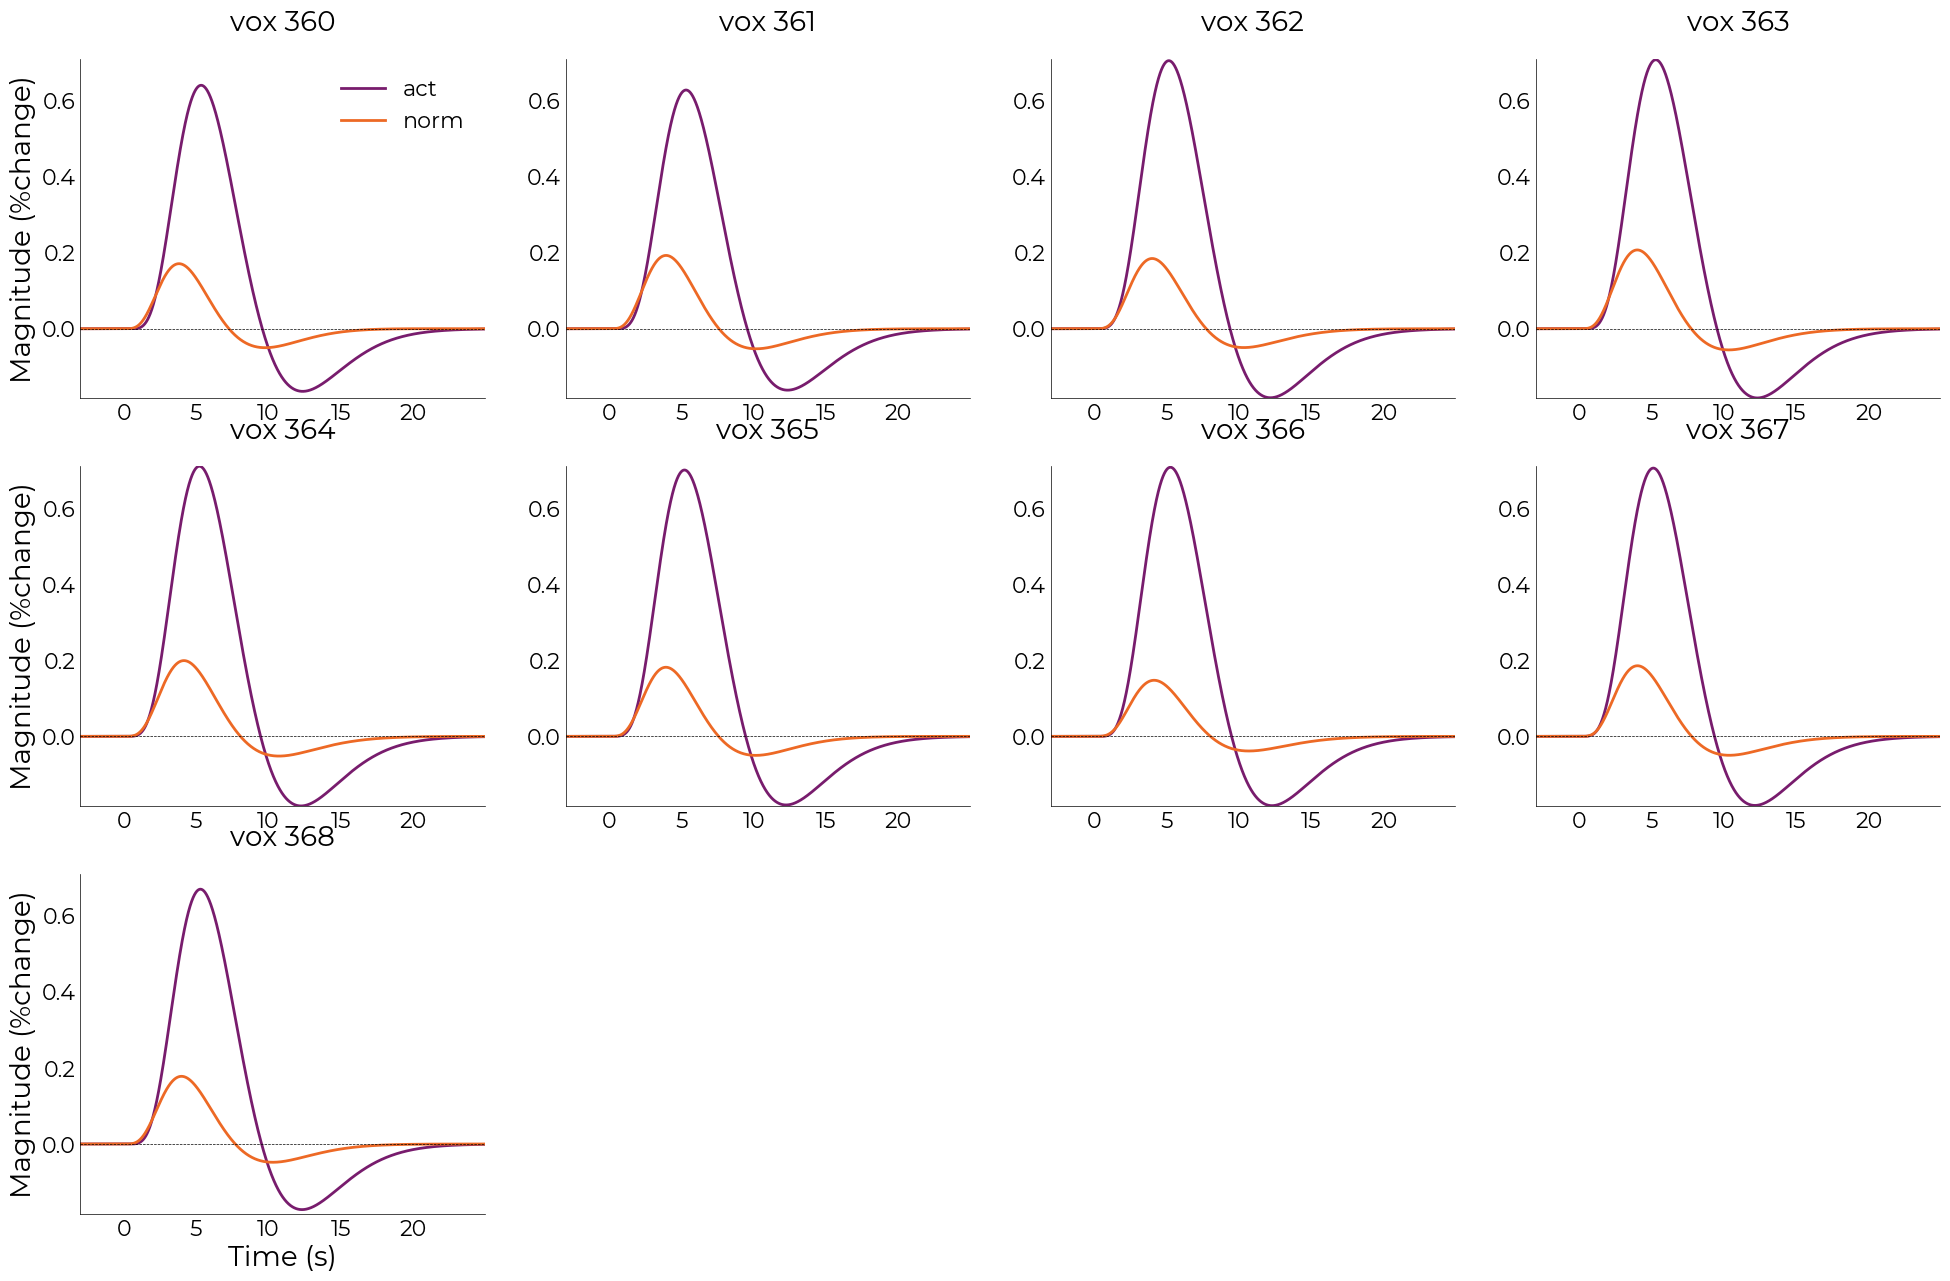

In [326]:
can_fit.plot_average_per_voxel(
    labels=can_fit.cond,
    wspace=0.2,
    cmap="inferno",
    line_width=2,
    font_size=font_size,
    label_size=16,
    sharey=True)


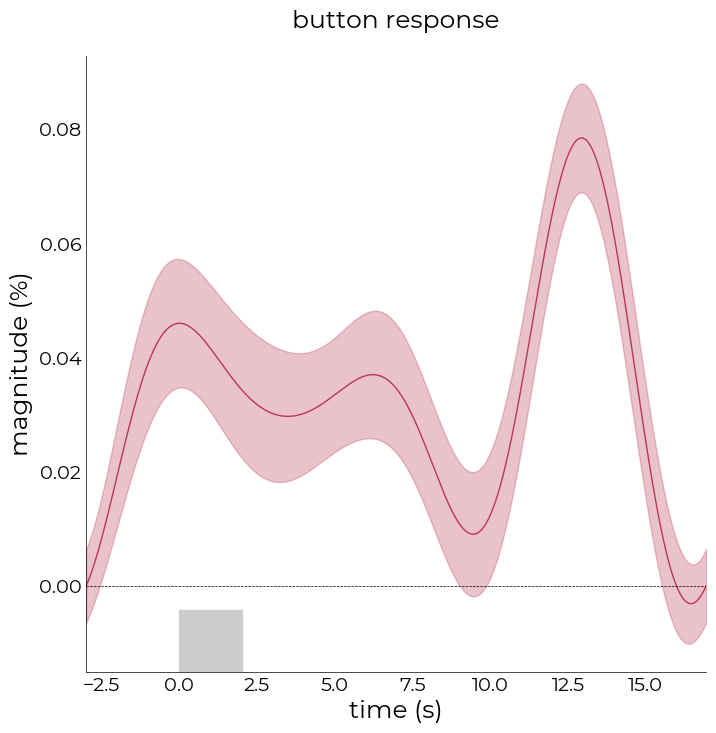

In [170]:
# %matplotlib inline
# fig,axs = plt.subplots(figsize=(8,8))
# fit_button.plot_average_per_event(
#     x_label="time (s)",
#     y_label="magnitude (%)",
#     add_hline='default',
#     axs=axs,
#     title="button response",
#     add_labels=True,
#     fancy=True,
#     fancy_denom=6,
#     inset_ttp=[0.75, 0.8, 0.3],
#     cmap='inferno')

# # plot stimulus onset
# axs.axvspan(0,2, ymax=0.1, color="#cccccc")

### Split events over voxels

In [157]:
df_ribbon.shape

(6400, 6)

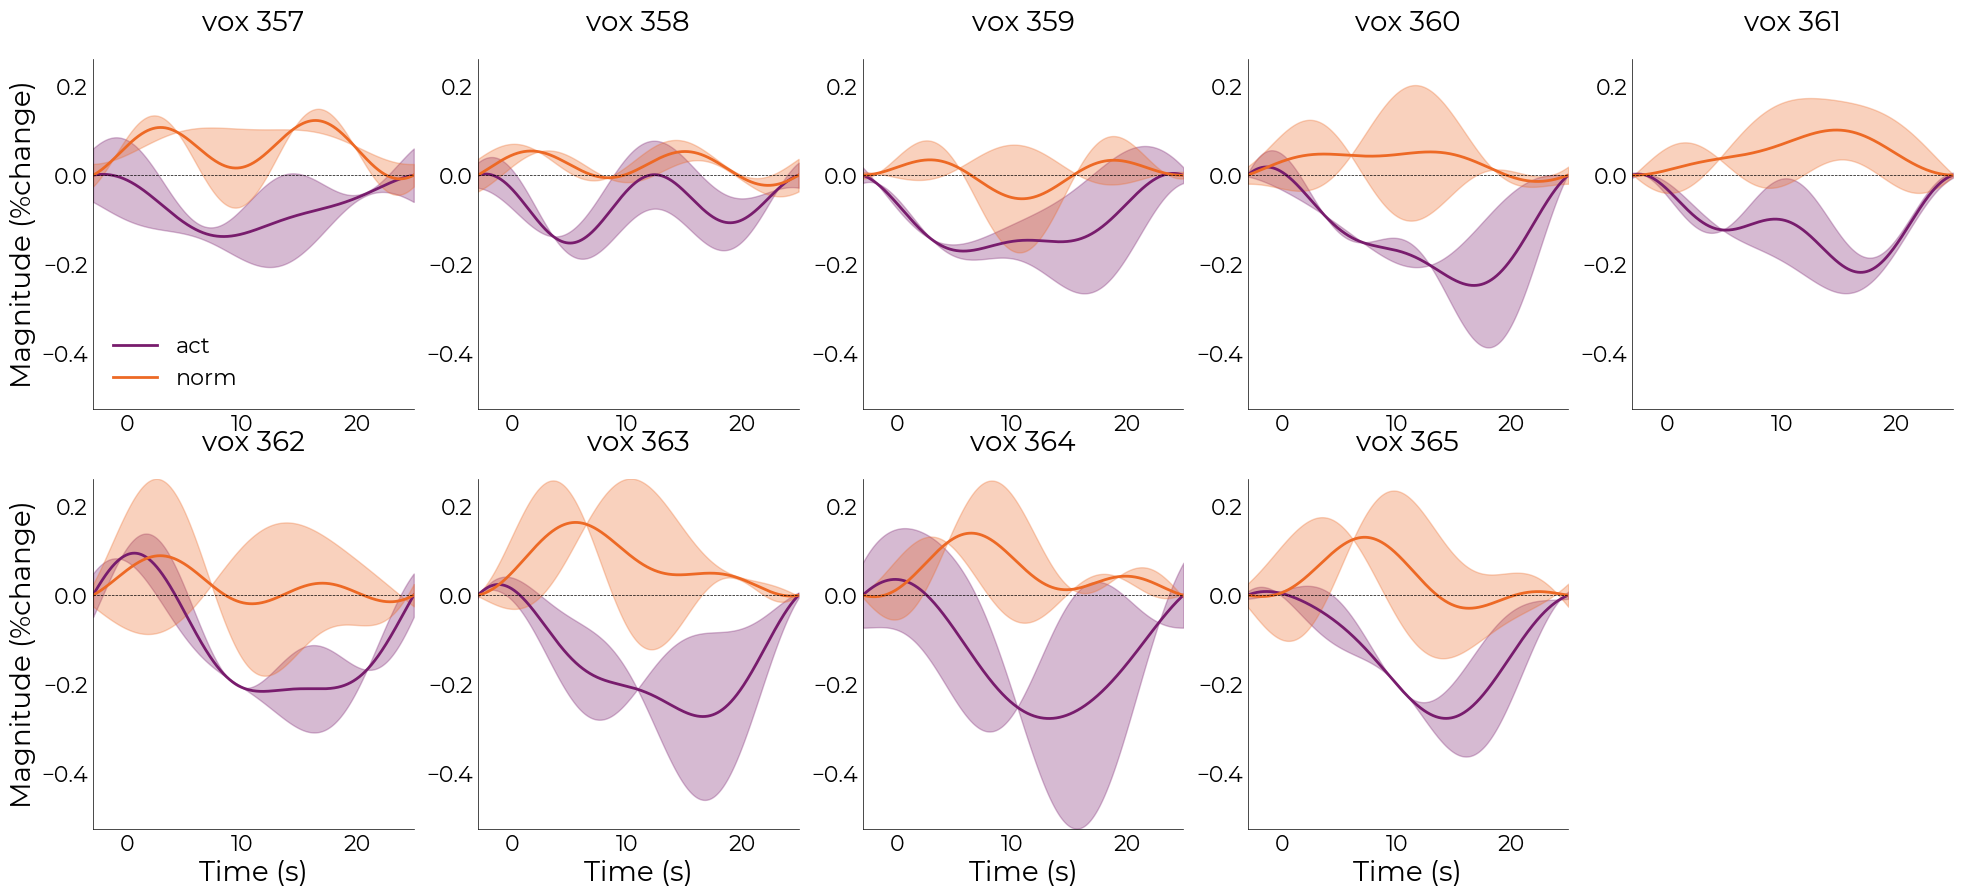

In [39]:
fou_fit.plot_average_per_voxel(
    labels=can_fit.cond,
    wspace=0.2,
    # n_cols=df_ribbon.shape[-1],
    n_cols=5,
    cmap="inferno",
    line_width=2,
    font_size=20,
    label_size=16,
    sharey=True)
    # save_as=opj(func_dir, "hrf_gamma_voxel.png"))